# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import transforms
from scipy import ndimage
from scipy.io import loadmat
from scipy import stats
import random
import time
import json
import os
import nibabel as nib
import pickle as pk
from scipy import interpolate

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

#In your imports you are mixing keras and tf.keras, which are NOT compatible with each other, as you get weird errors like these.

#So a simple solution is to choose keras or tf.keras, and make all imports from that package, and never mix it with the other.

# read battery MRI data

In [ ]:
rscale=np.array([7.40000000e-05, 1.97920635e-03, 3.88441270e-03, 5.78961905e-03,
       7.69482540e-03, 9.60003175e-03, 1.15052381e-02, 1.34104444e-02,
       1.53156508e-02, 1.72208571e-02, 1.91260635e-02, 2.10312698e-02,
       2.29364762e-02, 2.48416825e-02, 2.67468889e-02, 2.86520952e-02,
       3.05573016e-02, 3.24625079e-02, 3.43677143e-02, 3.62729206e-02,
       3.81781270e-02, 4.00833333e-02, 4.19885397e-02, 4.38937460e-02,
       4.57989524e-02, 4.77041587e-02, 4.96093651e-02, 5.15145714e-02,
       5.34197778e-02, 5.53249841e-02, 5.72301905e-02, 5.91353968e-02,
       6.10406032e-02, 6.29458095e-02, 6.48510159e-02, 6.67562222e-02,
       6.86614286e-02, 7.05666349e-02, 7.24718413e-02, 7.43770476e-02,
       7.62822540e-02, 7.81874603e-02, 8.00926667e-02, 8.19978730e-02,
       8.39030794e-02, 8.58082857e-02, 8.77134921e-02, 8.96186984e-02,
       9.15239048e-02, 9.34291111e-02, 9.53343175e-02, 9.72395238e-02,
       9.91447302e-02, 1.01049937e-01, 1.02955143e-01, 1.04860349e-01,
       1.06765556e-01, 1.08670762e-01, 1.10575968e-01, 1.12481175e-01,
       1.14386381e-01, 1.16291587e-01, 1.18196794e-01, 1.20102000e-01])
cscale=np.array([0.001     , 0.00229032, 0.00358065, 0.00487097, 0.00616129,
       0.00745161, 0.00874194, 0.01003226, 0.01132258, 0.0126129 ,
       0.01390323, 0.01519355, 0.01648387, 0.01777419, 0.01906452,
       0.02035484, 0.02164516, 0.02293548, 0.02422581, 0.02551613,
       0.02680645, 0.02809677, 0.0293871 , 0.03067742, 0.03196774,
       0.03325806, 0.03454839, 0.03583871, 0.03712903, 0.03841935,
       0.03970968, 0.041     ])

# set up grid for mag-suscept map

In [ ]:
battery_dims=np.array([5,30,40])*1e-3;
cell_dims=np.array([5,50,60])*1e-3;
# probe_dist=1.59e-4; 
npts=[1,16,32];
dV=np.prod(cell_dims/npts); 

In [ ]:
1.59e1

15.9

In [ ]:
# re-adjust for centering-----------------------------------------------------------------------------------------------------------------------------
# for first data
centery=0.021;
centerz=0.06;

# for second data
centery=0.015;
centerz=0.077;

# for damaged cell data
centery=0.020;
centerz=0.065;

# for new send data
centery=0.021;
centerz=0.062;

# convert both the magnetic susceptibility grid positions and the magnetic field positions into lists of the form `[x1,y1,z1; x2,y2,z2; etc ]`

In [ ]:
# for mag-suscep
srcpos=[[],[],[]]
for i in range(3):
    srcpos[i]=np.linspace(0,cell_dims[i],npts[i]+2)
    srcpos[i]=srcpos[i][1:(npts[i]+1)]
# recenter all y and z coordinates
srcpos[1]=srcpos[1]+centery-cell_dims[1]/2
srcpos[2]=srcpos[2]+centerz-cell_dims[2]/2

srcxv,srcyv,srczv=np.meshgrid(srcpos[0],srcpos[1],srcpos[2],indexing='ij')

src_fulllength=np.prod(npts)
src_pos_list=np.concatenate((srcxv.reshape((src_fulllength,1)),srcyv.reshape((src_fulllength,1)),
                             srczv.reshape((src_fulllength,1))),axis=1)

In [ ]:
rv, cv = np.meshgrid(rscale, cscale, indexing='ij')
fulllength=np.prod(rv.shape)
# field_pos_list=np.concatenate((cv.reshape((fulllength,1)),rv.reshape((fulllength,1))),axis=1)
# field_pos_list=np.insert(field_pos_list,0,probe_dist,axis=1)

In [ ]:
# make a dictionary of all the different field_pos_lists generated with different probe_distances

field_dict = dict()

for i in range(-8, 2, 1):
  probe_dist=1.59*10**i;
  print(probe_dist)
  field_pos_list=np.concatenate((cv.reshape((fulllength,1)),
                                rv.reshape((fulllength,1))
                                ),
                                axis=1)
  field_pos_list=np.insert(field_pos_list,0,probe_dist,axis=1)

  field_dict[i] = field_pos_list

print(100*'*')

1.59e-08
1.59e-07
1.59e-06
1.5900000000000004e-05
0.00015900000000000002
0.00159
0.0159
0.15900000000000003
1.59
15.9
****************************************************************************************************


In [ ]:
field_dict.keys()

dict_keys([-8, -7, -6, -5, -4, -3, -2, -1, 0, 1])

In [ ]:
field_dict[0] == field_dict[-2]

array([[False,  True,  True],
       [False,  True,  True],
       [False,  True,  True],
       ...,
       [False,  True,  True],
       [False,  True,  True],
       [False,  True,  True]])

# set up conversion matrix between magn. susceptibility and magn. field
so that we have $\mathbf{B}(field)=A \cdot \mathbf{m} (suscept)$ as a matrix-vector multiplication

In [ ]:
# modified for multidim to include multiple field components (y-z)
# now modif for x-y-z source dims

oneD=False   # to do z-only calc in this framework for magnetic susceptibility (may be more stable)

# make a dict of different A tensors generated by different mag-field tensors
A_dict = dict()

for key in field_dict.keys():
  field_pos_list = field_dict[key]

  # make sure to reshape such that multiply the correct field components
  # A matrix is not very sparse, so maybe faster to do in non-sparse setup
  fpl=field_pos_list.shape[0]
  A=np.zeros((2,field_pos_list.shape[0],src_pos_list.shape[0],3),dtype=float)
  for i in range(src_pos_list.shape[0]):
    # for every point in the source position, aka cell grid 
      posdiff=src_pos_list[i,:]-field_pos_list
        # this is a broadcasted operation
        # posdiff is field_pos_list but every row is subtracted from ths ith row in suscept_pos_list
      inv_r=1/np.sqrt(np.sum(posdiff**2,axis=1))
        # performed for each row
      inv_r5=inv_r**5
      inv_r3=inv_r**3
      
      for fidx in range(2):
          fidx2=fidx+1    # this is the real dim index (compatible with sidx)
                          # since I only have y and z components of the field
          
          if oneD:
              sidx=2
              A[fidx,:,i,sidx]=3*posdiff[:,fidx2]*posdiff[:,sidx]*inv_r5
              # A[0, :, i, 2] = 3*posdiff[:,1]*posdiff[:,2] * inv_r5
              # A[1, :, i, 2] = 3*posdiff[:,2]*posdiff[:,2] * inv_r5
              if sidx==fidx2:
                  A[fidx,:,i,sidx]=A[fidx,:,i,sidx]-inv_r3
                  #A[1, :, i, 2] = A[1, :, i, 2] - inv_r3
          else:
              for sidx in range(3):
                  A[fidx,:,i,sidx]=3*posdiff[:,fidx2]*posdiff[:,sidx]*inv_r5
                  #A[0, :, i, 0] = 3*posdiff[:, 1] * posdiff[:,0] * inv_r5
                  #A[0, :, i, 1] = 3*posdiff[:, 1] * posdiff[:,1] * inv_r5
                  #A[0, :, i, 2] = 3*posdiff[:, 1] * posdiff[:,2] * inv_r5
                  #A[1, :, i, 0] = 3*posdiff[:, 2] * posdiff[:,0] * inv_r5
                  #A[1, :, i, 1] = 3*posdiff[:, 2] * posdiff[:,1] * inv_r5
                  #A[1, :, i, 2] = 3*posdiff[:, 2] * posdiff[:,2] * inv_r5
                  if sidx==fidx2:
                      A[fidx,:,i,sidx]=A[fidx,:,i,sidx]-inv_r3
                      #A[0, :, i, 1] = A[0, :, i, 1] - inv_r3
                      #A[1, :, i, 2] = A[1, :, i, 2] - inv_r3
      
  A_dict[key]=A.reshape((fpl*2,src_pos_list.shape[0]*3))

In [ ]:
assert A_dict.keys() == field_dict.keys()

In [ ]:
assert np.any(A_dict[0] != A_dict[-2])

In [ ]:
for key in A_dict.keys():
  # proper conversion units
  B0=20e-6
  A_dict[key]=A_dict[key]*dV*B0/4/np.pi

# generate training set

In [ ]:
num_sim2=300 #can adjust, higher means slower training time but more accurate model

In [ ]:
# function to forwardly calculate mag-field from synthetic mag-suscept
def calcfield(suscept, A):
  '''
  input:
    suscept: a 3-D array of magnetic susceptibility, must have the same shape as npts
    A: the 'A' coefficient tensor corresponding to the suscept generated from the different mag-field position grids
  return:
    fieldy: 2-D matrix of the y-component of magnetic field vector space
    fieldz: 2-D matrix of the z-component of magnetic field vector space
  '''
  source_vec=np.squeeze(suscept[:,:,:]).reshape((src_fulllength*3,1))
  magfield=np.dot(A,source_vec)
  fieldy = magfield[0:fpl,0].reshape((rv.shape[0],rv.shape[1]))
  fieldz = magfield[fpl:2*fpl,0].reshape((rv.shape[0],rv.shape[1]))
  return fieldy, fieldz

In [ ]:
# generate random magntic susceptibility distributions, based on a set of random gaussian peaks 

# genearte 1 set of data for each different probe_dist
# this will be a dictionary of dictionaries
set_dict = dict()

for key in A_dict.keys():
  data_dict = dict()
  training_labels=np.zeros((num_sim2, npts[2], npts[1],3)) 
  training_data=np.zeros((num_sim2, rv.shape[0], rv.shape[1],2))
  maxlevelrange=200e-6
  numberpeaks=10;
  idx1=range(npts[2])
  idx2=range(npts[1])
  midx1,midx2=np.meshgrid(idx1,idx2,indexing='ij')
  for ii in range(num_sim2):
    # for now just produce z susceptibility (easier for checking result?)
    # here provide alternative training set  exp(-x^2/(2sigma^2))
    if True:
      for iii in range(numberpeaks):
          pos1=np.random.rand(1)*npts[2]
          pos2=np.random.rand(1)*npts[1]
          w1=np.random.rand(1)*npts[2]/5+1
          w2=np.random.rand(1)*npts[1]/5+1
          amp=np.random.rand(1)*maxlevelrange
          training_labels[ii, :, :,2]=training_labels[ii, :, :,2]+amp*np.exp(-((midx1-pos1)/w1)**2-((midx2-pos2)/w2)**2)
    else:
      # for network best to create the susceptibility in the transposed version
      #training_labels[ii, :, :,2] = maxlevelrange*np.random.rand(npts[1], npts[2])
      training_labels[ii, :, :,2] = maxlevelrange*np.random.rand(npts[2], npts[1])  # only z susceptibility for now 
        
    training_data[ii, :, :,0],training_data[ii, :, :,1] = calcfield(training_labels[ii,:,:,:], A_dict[key])
    # so the input data will be the mag-field, chanel 0 will be y-component, chanel 1 will be z-component
    # the output, or what we are trying to predict, are the mag susceptibilities

  # train, validation, and test split-------------------------------------------------------------------------------------------------------------

  # a list of random indices thats 40% of the samples
  val_test_idx = random.sample(range(num_sim2), int(0.4*num_sim2))
  # get the remainder of the indices as train
  train_idx = np.setdiff1d(range(num_sim2),val_test_idx)

  val_data = training_data[val_test_idx[:int(0.4*num_sim2/2)], :, :, :]
  val_labels = training_labels[val_test_idx[:int(0.4*num_sim2/2)], :, :, :]

  test_data = training_data[val_test_idx[int(0.4*num_sim2/2):], :, :, :]
  test_labels = training_labels[val_test_idx[int(0.4*num_sim2/2):], :, :, :]

  train_data = training_data[train_idx, :, :, :]
  train_labels = training_labels[train_idx, :, :, :]

  # TF requires this kind of transformation into tensor
  train_images_t2b=tf.constant(train_data)
  train_labels_t2b=tf.constant(train_labels)

  val_images_t2b=tf.constant(val_data)
  val_labels_t2b=tf.constant(val_labels)

  test_images_t2b=tf.constant(test_data)
  test_labels_t2b=tf.constant(test_labels)

  data_dict['train_images_t2b'] = train_images_t2b
  data_dict['train_labels_t2b'] = train_labels_t2b
  data_dict['val_images_t2b'] = val_images_t2b
  data_dict['val_labels_t2b'] = val_labels_t2b
  data_dict['test_images_t2b'] = test_images_t2b
  data_dict['test_labels_t2b'] = test_labels_t2b

  # put this dictionary of datasets into the dictionary of different probe_dist
  set_dict[key] = data_dict

In [ ]:
set_dict.keys()

dict_keys([-8, -7, -6, -5, -4, -3, -2, -1, 0, 1])

In [ ]:
set_dict[-2].keys()

dict_keys(['train_images_t2b', 'train_labels_t2b', 'val_images_t2b', 'val_labels_t2b', 'test_images_t2b', 'test_labels_t2b'])

For each distance, I have a set of 6 datasets, `trainx`, `trainy`, `valx`, `valy`, `testx`, `testy`.

In [ ]:
# make sure we have actually generated different data based on differet probe_dist
assert np.any(set_dict[-2]['train_images_t2b'] != set_dict[0]['train_images_t2b'])

In [ ]:
def imshow_center(data):
  '''
  Display 1 chanel of the data as an image; i.e. on a 2D regular raster.
  input:
    data: a single battery's 
      magnetic field image that is a 2-D array with shape [64,32] with scalar data,
      or magnetic susceptibility image that is a 2-D array with shape [32,16]
  output:
    figure/image displaying all the range of values
  '''
  maxval=np.max(np.abs(data))
  plt.imshow(data, cmap="seismic",vmin=-maxval,vmax=maxval)
  plt.colorbar()

In [ ]:
print((set_dict[-2]['train_images_t2b'][33,:,:,0]).shape)
print((set_dict[-2]['train_images_t2b'][33,:,:,1]).shape)
print((set_dict[-2]['train_images_t2b']).shape)

(64, 32)
(64, 32)
(180, 64, 32, 2)


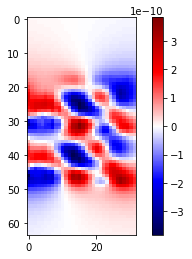

In [ ]:
imshow_center(set_dict[-4]['train_images_t2b'][33,:,:,0])
# plt.savefig('training_sample.png')

The 33rd battery's magnetic field generated from the `-4` distance.

In [ ]:
print((set_dict[-4]['train_labels_t2b'][33,:,:,0]).shape)
print((set_dict[-4]['train_labels_t2b'][33,:,:,1]).shape)
print((set_dict[-4]['train_labels_t2b'][33,:,:,2]).shape)
print((set_dict[-4]['train_labels_t2b']).shape)

(32, 16)
(32, 16)
(32, 16)
(180, 32, 16, 3)


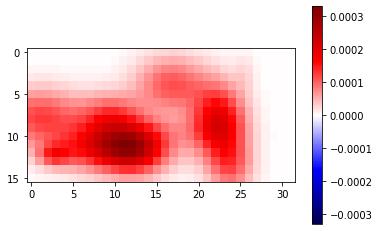

In [ ]:
# for historical reasons, the magnetic susceptibility map shows up transpose, 
# I guess it would be good to change that at some point, but for now keeping it 
imshow_center(np.transpose(set_dict[-4]['train_labels_t2b'][33,:,:,2]))
plt.savefig('label_sample.png')

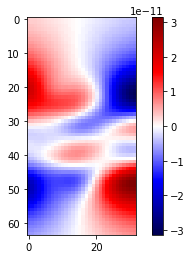

In [ ]:
imshow_center(set_dict[-2]['train_images_t2b'][33,:,:,0])
# plt.savefig('training_sample.png')

In [ ]:
print((set_dict[-2]['train_labels_t2b'][33,:,:,0]).shape)
print((set_dict[-2]['train_labels_t2b'][33,:,:,1]).shape)
print((set_dict[-2]['train_labels_t2b'][33,:,:,2]).shape)
print((set_dict[-2]['train_labels_t2b']).shape)

(32, 16)
(32, 16)
(32, 16)
(180, 32, 16, 3)


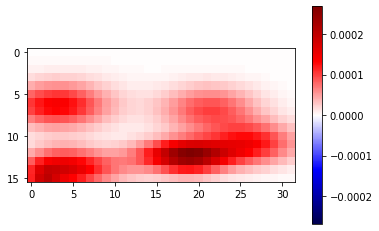

In [ ]:
# for historical reasons, the magnetic susceptibility map shows up transpose, 
# I guess it would be good to change that at some point, but for now keeping it 
imshow_center(np.transpose(set_dict[-2]['train_labels_t2b'][33,:,:,2]))
os.mkdir('-2')
plt.savefig('-2/label_sample.png')

In [ ]:
!rm -r *.png

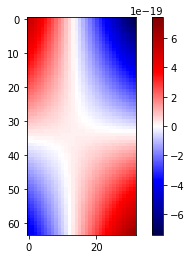

In [ ]:
imshow_center(set_dict[0]['train_images_t2b'][33,:,:,0])
# plt.savefig('training_sample.png')

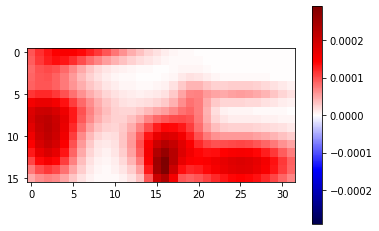

In [ ]:
# for historical reasons, the magnetic susceptibility map shows up transpose, 
# I guess it would be good to change that at some point, but for now keeping it 
imshow_center(np.transpose(set_dict[0]['train_labels_t2b'][33,:,:,2]))
# plt.savefig('label_sample.png')

we see a pattern that the larger the `probe_dist`, the smaller the changes in the magnetic field.

# Model setup
model based on papers (Bollman, etc) with some modifications, links given

## define model functions

In [ ]:
def get_figure():
    """
    Returns:
      an emtpy figure and an empty axis objects to plot on. 
    
    Removes top and right border and ticks, because those are ugly
    """
    fig, ax = plt.subplots(1)
    plt.tick_params(top=False, right=False, which='both') 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

def conv_block_h2(input_tensor, num_filters, dropout_level = 0.15):
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Dropout(dropout_level)(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

def encoder_block_h2(input_tensor, num_filters, dropout_level = 0.15):
    encoder = layers.BatchNormalization()(input_tensor) # added a first normalization layer
    encoder = conv_block_h2(input_tensor, num_filters)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    return encoder_pool, encoder

def decoder_block_h2(input_tensor, concat_tensor, num_filters, dropout_level = 0.15):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Dropout(dropout_level)(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    return decoder



## define loss functions

In [ ]:
def custom_loss_mse(y_true,y_pred):
    loss=K.mean(K.square(y_pred-y_true),axis=None)  #+K.sum(0*K.abs(penalty)) #can adjust the penalty weight
    return loss

def custom_loss_rmse(y_true,y_pred):
    loss=K.sqrt(K.mean(K.square(y_pred-y_true),axis=None))  #+K.sum(0*K.abs(penalty)) #can adjust the penalty weight
    return loss

def custom_loss_abs(y_true,y_pred):
    loss=K.mean(K.abs(y_pred-y_true),axis=None)  #+K.sum(0*K.abs(penalty)) #can adjust the penalty weight
    return loss

# 'Grid Search' (but really, just use 1 set of the best parameters) model on different datasets

In [ ]:
[i*64 for i in range(4,0,-1)]

[256, 192, 128, 64]

In [ ]:
dist=-2
str(dist)+'/test_20_difference.png'

'-2/test_20_difference.png'

In [ ]:
def grid_search(train_images_t2b, train_labels_t2b, val_images_t2b, val_labels_t2b, dist,
                dropout_level_lst=[0.05], beta2_lst=[0.999], beta1_lst=[0.9], lr_rate_lst = [0.001],
                epsilon_lst=[1e-08], epo_lst = [3000], bat_size_lst = [128]
                ):
  # initialize values
  val_loss = np.inf
  best_params = dict()
  dist=dist

  for dp_level in dropout_level_lst:
    inputs_h2 = layers.Input(shape=(64,32,2))
    # same as (rscale, cscale, 2)
    # also same as the dimension for EACH image in the training set
    encoder0_pool_h2, encoder0_h2 = encoder_block_h2(inputs_h2, 8, dropout_level=dp_level)
    encoder1_pool_h2, encoder1_h2 = encoder_block_h2(encoder0_pool_h2, 16, dropout_level=dp_level)
    encoder2_pool_h2, encoder2_h2 = encoder_block_h2(encoder1_pool_h2, 32, dropout_level=dp_level)
    encoder3_pool_h2, encoder3_h2 = encoder_block_h2(encoder2_pool_h2, 64, dropout_level=dp_level)
    center_h2 = conv_block_h2(encoder3_pool_h2, 128, dropout_level=dp_level)
    decoder3_h2 = decoder_block_h2(center_h2, encoder3_h2, 64, dropout_level=dp_level)
    decoder2_h2 = decoder_block_h2(decoder3_h2, encoder2_h2, 32, dropout_level=dp_level)
    decoder1_h2 = decoder_block_h2(decoder2_h2, encoder1_h2, 16, dropout_level=dp_level)
    outputs_h2 = layers.Conv2D(3, (1, 1), padding="same")(decoder1_h2)   # simply set number of output channels here, seems legit

    model_ht2b = models.Model(inputs=[inputs_h2], outputs=[outputs_h2])

    for beta2 in beta2_lst:
      for beta1 in beta1_lst:
        for lr_rate in lr_rate_lst:
          for eps in epsilon_lst:
            adam=keras.optimizers.Adam(learning_rate = lr_rate, beta_1 = beta1, beta_2=beta2, epsilon = eps)

            model_ht2b.compile(optimizer=adam,
                               loss=custom_loss_rmse) # let's use rmse for optimization becuase it is a bigger target than mse

            # construct checkpoint for saving the best model for current training
            curr_best_filepath=str(dist)+"/current.best.h5"
            checkpoint = ModelCheckpoint(curr_best_filepath, 
                                        monitor='val_loss', # this must be the same string as a metric from your model training verbose output
                                        verbose=1, 
                                        save_best_only=True, # only save the model if it out-performs all previous ones
                                        mode='min', # we want minimum loss
                                        save_weights_only=False # we want to save the entire model, not just the weights
                                        )
            callbacks_list = [checkpoint]

            for epo in epo_lst:
              for bat_size in bat_size_lst:
                start = time.time()
                history_ht2b = model_ht2b.fit(train_images_t2b, 
                                              train_labels_t2b,
                                              validation_data = (val_images_t2b, val_labels_t2b),  
                                              epochs=epo, 
                                              batch_size=bat_size, 
                                              shuffle=True,
                                              callbacks = callbacks_list,
                                              verbose=1)
                training_time = time.time()-start
                
                # load best model from current training b/c the best model might not be the last model
                model_ht2b = tf.keras.models.load_model(curr_best_filepath, 
                                                        custom_objects={'custom_loss_rmse': custom_loss_rmse})
                new_loss = custom_loss_rmse(val_labels_t2b, model_ht2b.predict(val_images_t2b))
                
                if new_loss.numpy() < val_loss:
                  print()
                  print('final validation loss decreased from ', val_loss, ' to ', new_loss.numpy())
                  print('saving the current best model as the overall best model')
                  print(100*'*')
                  val_loss = new_loss.numpy()
                  
                  best_params['best_dropout_rate'] = dp_level
                  best_params['best_beta_2'] = beta2
                  best_params['best_beta_1'] = beta1
                  best_params['best_learning_rate'] = lr_rate
                  best_params['best_epsilon'] = eps
                  best_params['best_epochs'] = epo
                  best_params['best_batch_size'] = bat_size

                  best_params['best_val_loss_reached'] = val_loss
                  best_params['training_time'] = training_time
                  best_params['val_loss_his'] = history_ht2b.history['val_loss']
                  best_params['train_loss_his'] = history_ht2b.history['loss']
                    # comment these out for now because they take way too much space when printed out 
                  
                  # save the best overall grid-searched model found so far 
                  best_filepath = str(dist)+'/model.best.h5'
                  model_ht2b.save(best_filepath)
                  
                  # save history of validation-loss from the best model to observe epochs effect
                  with open(str(dist)+'/best_val_loss_history.db', 'wb') as file_pi:
                    pk.dump(history_ht2b.history['val_loss'], file_pi)
                  # later open with 
                  # val_loss_history_ht2b = pk.load(open('best_val_loss_history.db', "rb"))

                  # save history of training-loss from the best model to observe epochs effect
                  with open(str(dist)+'/best_train_loss_history.db', 'wb') as file_pi:
                    pk.dump(history_ht2b.history['loss'], file_pi)
                  # later open with 
                  # train_loss_history_ht2b = pk.load(open('best_train_loss_history.db', "rb"))

                  # save the best_params dictionary along the way incase training gets killed mid-way and the function doesn't get to finish
                  # "w" mode automatically overwrites if the file already exists
                  param_json = json.dumps(best_params)
                  f = open(str(dist)+'/best_params.json',"w")
                  f.write(param_json)
                  f.close()

                  # save a plot of the val_loss_history for the best performing model for observation
                  fig, ax = get_figure()
                  fig.set_size_inches(20,10)
                  num_epochs=len(history_ht2b.history['val_loss'])
                  startpoints=0
                  ax.set_yscale('log') # set y-axis to log_10 scale for better viewing
                  ax.plot((np.arange(num_epochs*1)+1)[startpoints:], 
                          history_ht2b.history['loss'][startpoints:], 
                          linewidth=1, color="orange", 
                          label="training_loss")
                  ax.plot((np.arange(num_epochs*1)+1)[startpoints:], 
                          history_ht2b.history['val_loss'][startpoints:], 
                          linewidth=1, color="blue", 
                          label="validation loss")
                  ax.set_xlabel('epochs')
                  ax.set_ylabel('log loss')
                  ax.legend(frameon=False);
                  fig.savefig(str(dist)+'/best_model_loss_history.png')
                else:
                  print('final validation loss did not decrease for this set of parameters')
                  print('current overall best model and parameters does not get updated')
                  print(100*'*')
  return best_params

In [ ]:
set_dict[-2].keys()

dict_keys(['train_images_t2b', 'train_labels_t2b', 'val_images_t2b', 'val_labels_t2b', 'test_images_t2b', 'test_labels_t2b'])

directory already exists
Epoch 1/60
2/2 [==============================] - ETA: 0s - loss: 0.8253
Epoch 00001: val_loss improved from inf to 0.00608, saving model to -8/current.best.h5
2/2 [==============================] - 1s 456ms/step - loss: 0.8253 - val_loss: 0.0061
Epoch 2/60
1/2 [==============>...............] - ETA: 0s - loss: 0.6968
Epoch 00002: val_loss did not improve from 0.00608
2/2 [==============================] - 0s 24ms/step - loss: 0.6733 - val_loss: 0.0100
Epoch 3/60
1/2 [==============>...............] - ETA: 0s - loss: 0.5609
Epoch 00003: val_loss did not improve from 0.00608
2/2 [==============================] - 0s 22ms/step - loss: 0.5466 - val_loss: 0.0140
Epoch 4/60
1/2 [==============>...............] - ETA: 0s - loss: 0.4685
Epoch 00004: val_loss did not improve from 0.00608
2/2 [==============================] - 0s 23ms/step - loss: 0.4584 - val_loss: 0.0192
Epoch 5/60
1/2 [==============>...............] - ETA: 0s - loss: 0.4017
Epoch 00005: val_loss did

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


final RMSE loss on test set: 0.004750625758522081
final normalized RMSE loss (div mean) on the test set: 267.0638266095495
final normalized RMSE loss (div range) on the test set: 11.988823024811067
final normalized RMSE loss (div IQR) on the test set: 736.5489894408563
final norm of the difference tensor: 1.4421885799675043
final Bollman normalized RMSE loss on the test set: 102.35479687815973
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch 1/60
1/2 [==============>...............] - ETA: 0s - loss: 0.8977
Epoch 00001: val_loss improved from inf to 0.00594, saving model to -5/current.best.h5
2/2 [==============================] - 1s 280ms/step - loss: 0.8765 - val_loss: 0.0059
Epoch 2/60
1/2 [==============>...............] - ETA: 0s - loss: 0.7221
Epoch 00002: val_loss did not improve from 0.00594
2/2 [==============================] - 0s 23ms/step - loss: 0.7037 - val_loss: 0.0109
Epoch 3/60
1/2 [==============>..............

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning

final RMSE loss on test set: 0.0059382145853230815
final normalized RMSE loss (div mean) on the test set: 298.93977724403993
final normalized RMSE loss (div range) on the test set: 13.731921175847338
final normalized RMSE loss (div IQR) on the test set: 653.521881714547
final norm of the difference tensor: 1.802715199147509
final Bollman normalized RMSE loss on the test set: 116.33948300128645
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch 1/60
1/2 [==============>...............] - ETA: 0s - loss: 0.8660
Epoch 00001: val_loss improved from inf to 0.00230, saving model to -4/current.best.h5
2/2 [==============================] - 1s 302ms/step - loss: 0.8680 - val_loss: 0.0023
Epoch 2/60
1/2 [==============>...............] - ETA: 0s - loss: 0.7940
Epoch 00002: val_loss did not improve from 0.00230
2/2 [==============================] - 0s 22ms/step - loss: 0.7745 - val_loss: 0.0041
Epoch 3/60
1/2 [==============>..............

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning

final RMSE loss on test set: 0.0023010380844089196
final normalized RMSE loss (div mean) on the test set: 129.08018654713237
final normalized RMSE loss (div range) on the test set: 4.383633061819715
final normalized RMSE loss (div IQR) on the test set: 395.8137422370644
final norm of the difference tensor: 0.6985460476342048
final Bollman normalized RMSE loss on the test set: 48.2031825442873
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch 1/60
1/2 [==============>...............] - ETA: 0s - loss: 0.7877
Epoch 00001: val_loss improved from inf to 0.00149, saving model to -3/current.best.h5
2/2 [==============================] - 1s 285ms/step - loss: 0.7695 - val_loss: 0.0015
Epoch 2/60
1/2 [==============>...............] - ETA: 0s - loss: 0.6307
Epoch 00002: val_loss did not improve from 0.00149
2/2 [==============================] - 0s 22ms/step - loss: 0.6154 - val_loss: 0.0024
Epoch 3/60
1/2 [==============>...............

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning

final RMSE loss on test set: 0.0014915975801648627
final normalized RMSE loss (div mean) on the test set: 77.53109253229626
final normalized RMSE loss (div range) on the test set: 3.617135678977891
final normalized RMSE loss (div IQR) on the test set: 180.0587583527896
final norm of the difference tensor: 0.4528171877487896
final Bollman normalized RMSE loss on the test set: 30.08062920969496
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch 1/60
1/2 [==============>...............] - ETA: 0s - loss: 0.7809
Epoch 00001: val_loss improved from inf to 0.00333, saving model to -2/current.best.h5
2/2 [==============================] - 1s 286ms/step - loss: 0.7935 - val_loss: 0.0033
Epoch 2/60
1/2 [==============>...............] - ETA: 0s - loss: 0.7150
Epoch 00002: val_loss did not improve from 0.00333
2/2 [==============================] - 0s 22ms/step - loss: 0.6915 - val_loss: 0.0083
Epoch 3/60
1/2 [==============>...............

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning

final RMSE loss on test set: 0.0033302817762543746
final normalized RMSE loss (div mean) on the test set: 188.19118825498114
final normalized RMSE loss (div range) on the test set: 7.990966564769712
final normalized RMSE loss (div IQR) on the test set: 438.123495870588
final norm of the difference tensor: 1.0110024636590476
final Bollman normalized RMSE loss on the test set: 72.30606596743408
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch 1/60
1/2 [==============>...............] - ETA: 0s - loss: 0.8637
Epoch 00001: val_loss improved from inf to 0.00438, saving model to -1/current.best.h5
2/2 [==============================] - 1s 274ms/step - loss: 0.8598 - val_loss: 0.0044
Epoch 2/60
1/2 [==============>...............] - ETA: 0s - loss: 0.7771
Epoch 00002: val_loss did not improve from 0.00438
2/2 [==============================] - 0s 24ms/step - loss: 0.7616 - val_loss: 0.0061
Epoch 3/60
1/2 [==============>...............

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning

final RMSE loss on test set: 0.004381540853822924
final normalized RMSE loss (div mean) on the test set: 240.17477172015944
final normalized RMSE loss (div range) on the test set: 10.598654853142893
final normalized RMSE loss (div IQR) on the test set: 546.3835589462622
final norm of the difference tensor: 1.3301422808792949
final Bollman normalized RMSE loss on the test set: 93.52660166151578
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch 1/60
1/2 [==============>...............] - ETA: 0s - loss: 0.7582
Epoch 00001: val_loss improved from inf to 0.00266, saving model to 0/current.best.h5
2/2 [==============================] - 1s 283ms/step - loss: 0.7596 - val_loss: 0.0027
Epoch 2/60
1/2 [==============>...............] - ETA: 0s - loss: 0.6729
Epoch 00002: val_loss did not improve from 0.00266
2/2 [==============================] - 0s 22ms/step - loss: 0.6530 - val_loss: 0.0052
Epoch 3/60
1/2 [==============>...............

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning

final RMSE loss on test set: 0.0026588110247308524
final normalized RMSE loss (div mean) on the test set: 148.01106043280208
final normalized RMSE loss (div range) on the test set: 7.249058173530898
final normalized RMSE loss (div IQR) on the test set: 384.58298077513336
final norm of the difference tensor: 0.807158275787114
final Bollman normalized RMSE loss on the test set: 57.38317914094432
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Epoch 1/60
1/2 [==============>...............] - ETA: 0s - loss: 1.1031
Epoch 00001: val_loss improved from inf to 0.00388, saving model to 1/current.best.h5
2/2 [==============================] - 1s 277ms/step - loss: 1.1038 - val_loss: 0.0039
Epoch 2/60
1/2 [==============>...............] - ETA: 0s - loss: 1.0118
Epoch 00002: val_loss did not improve from 0.00388
2/2 [==============================] - 0s 23ms/step - loss: 0.9898 - val_loss: 0.0064
Epoch 3/60
1/2 [==============>...............

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning

final RMSE loss on test set: 0.003876450697469567
final normalized RMSE loss (div mean) on the test set: 208.9911514962406
final normalized RMSE loss (div range) on the test set: 6.694228288091322
final normalized RMSE loss (div IQR) on the test set: 501.18797400588954
final norm of the difference tensor: 1.1768076903698057
final Bollman normalized RMSE loss on the test set: 81.29718195508327
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


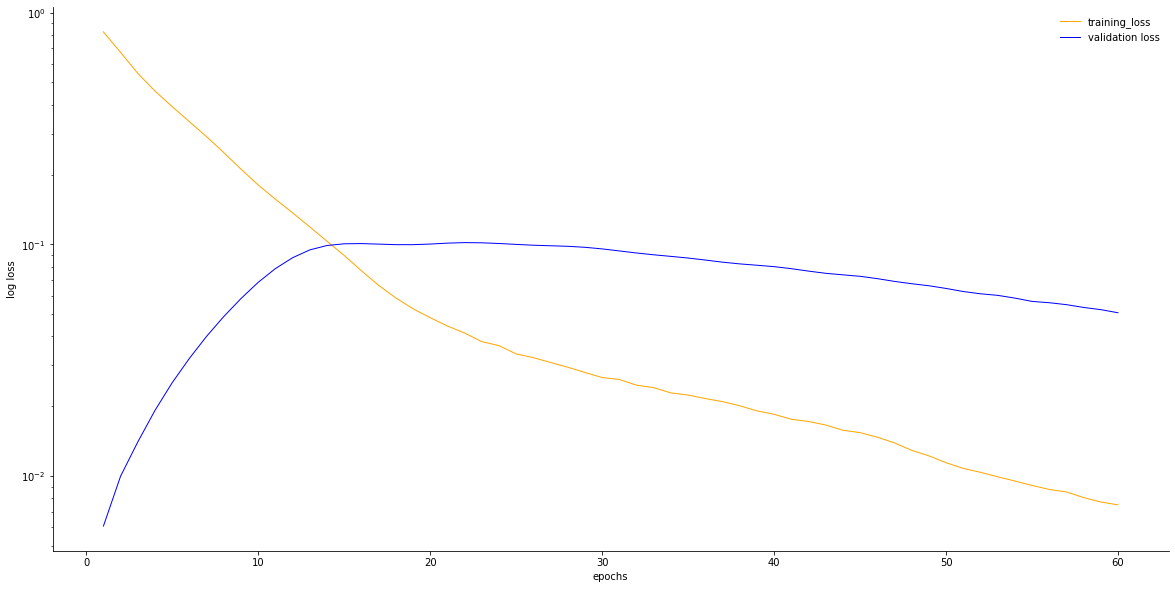

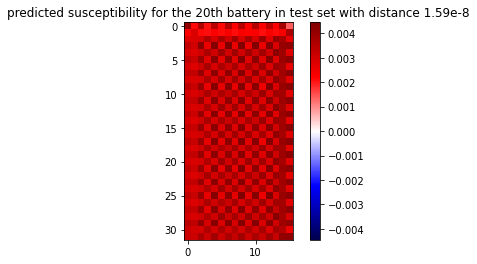

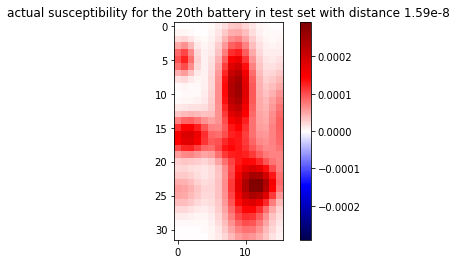

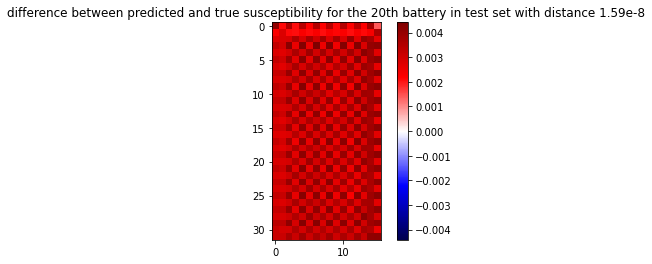

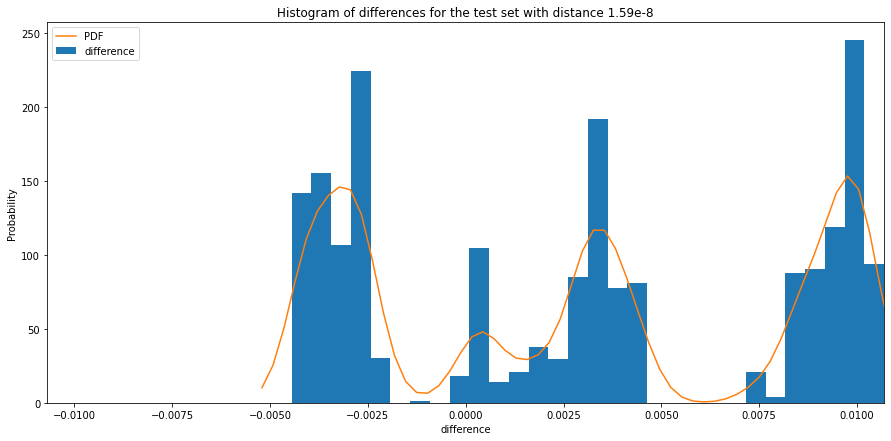

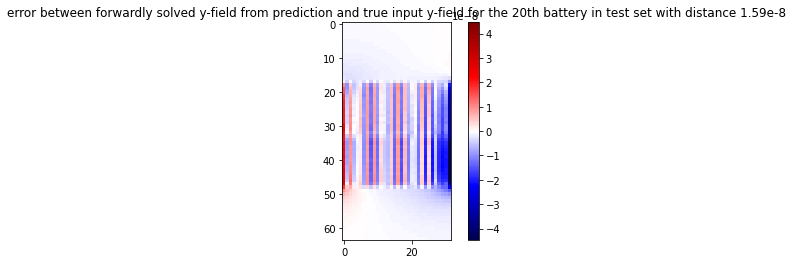

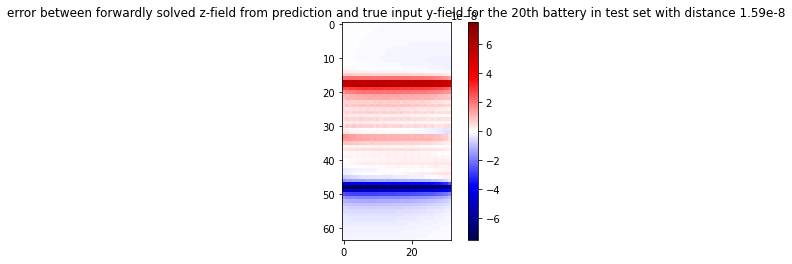

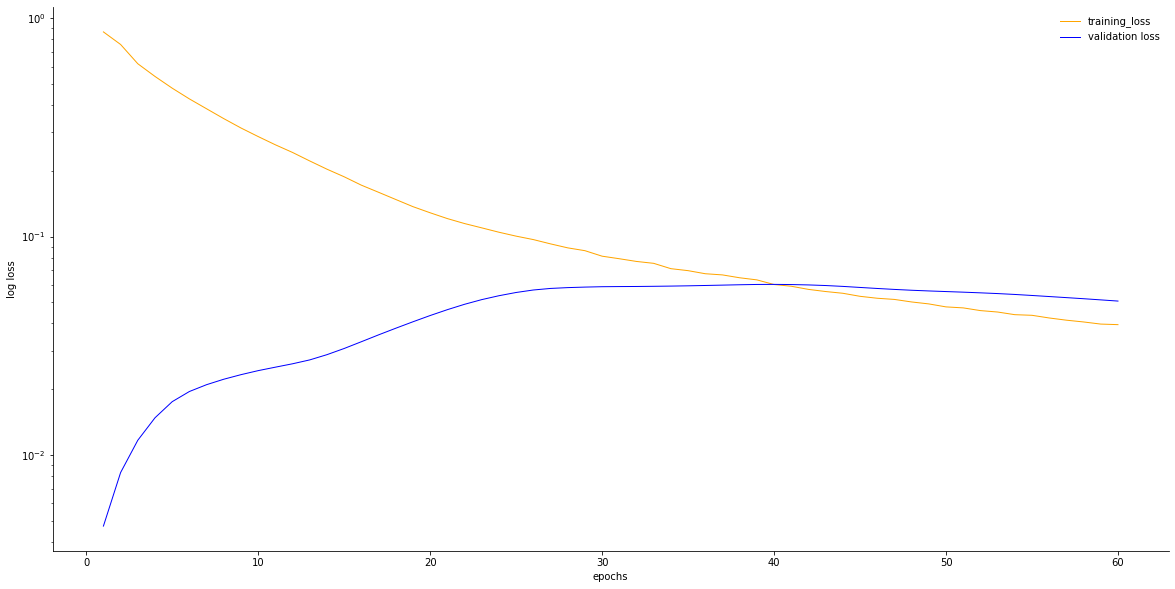

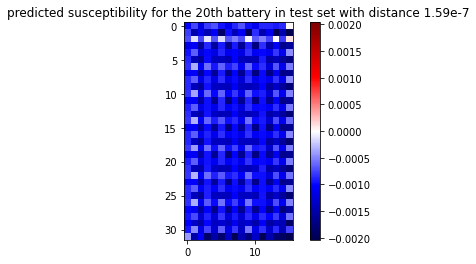

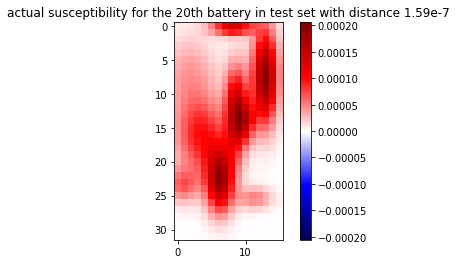

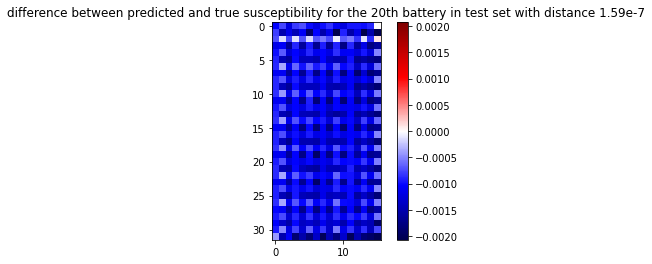

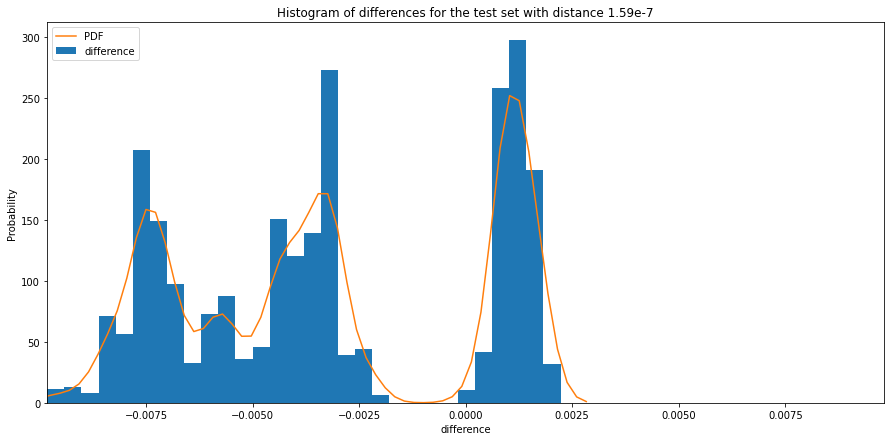

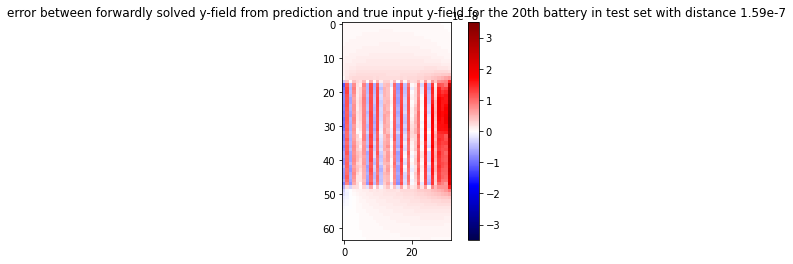

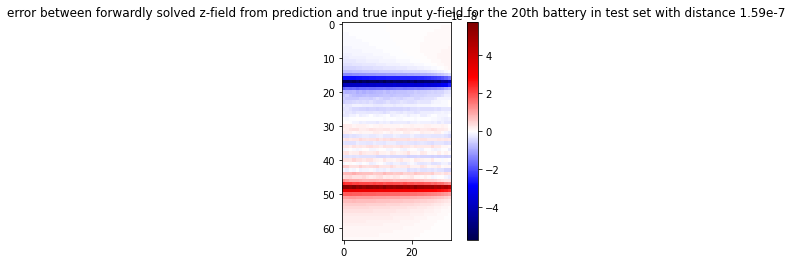

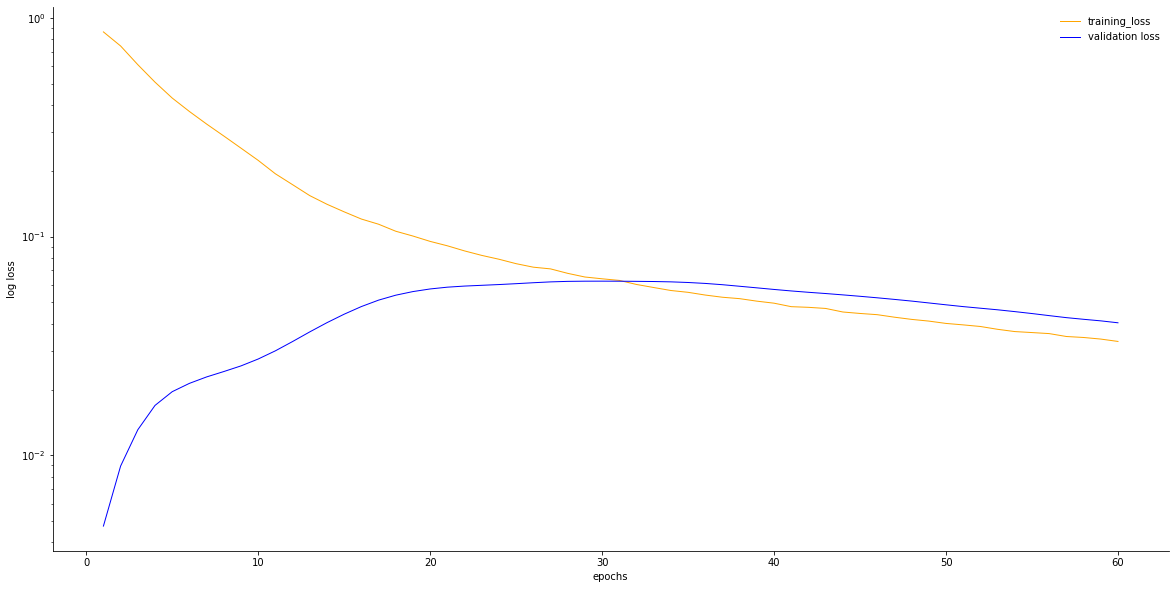

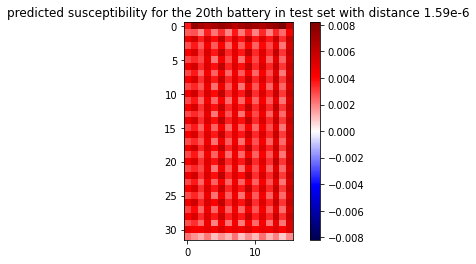

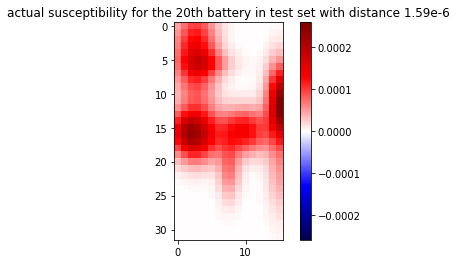

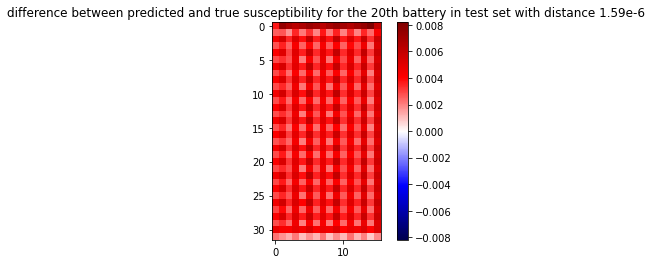

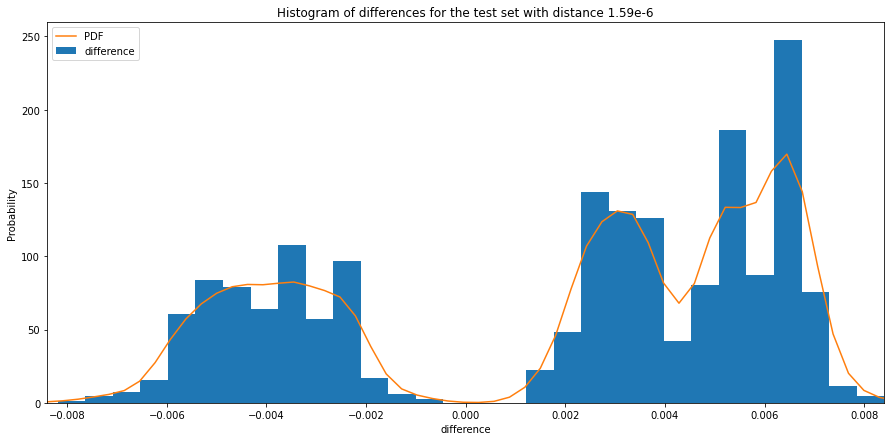

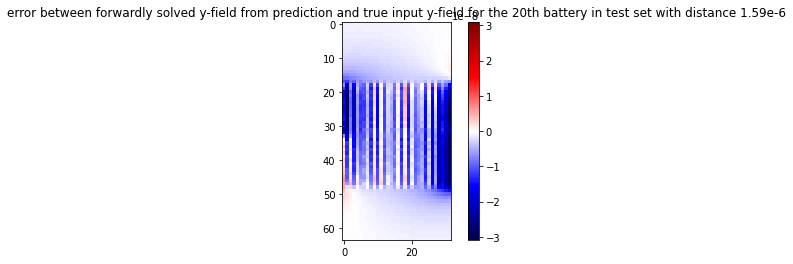

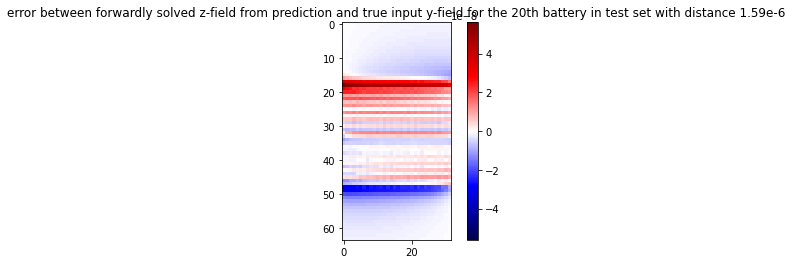

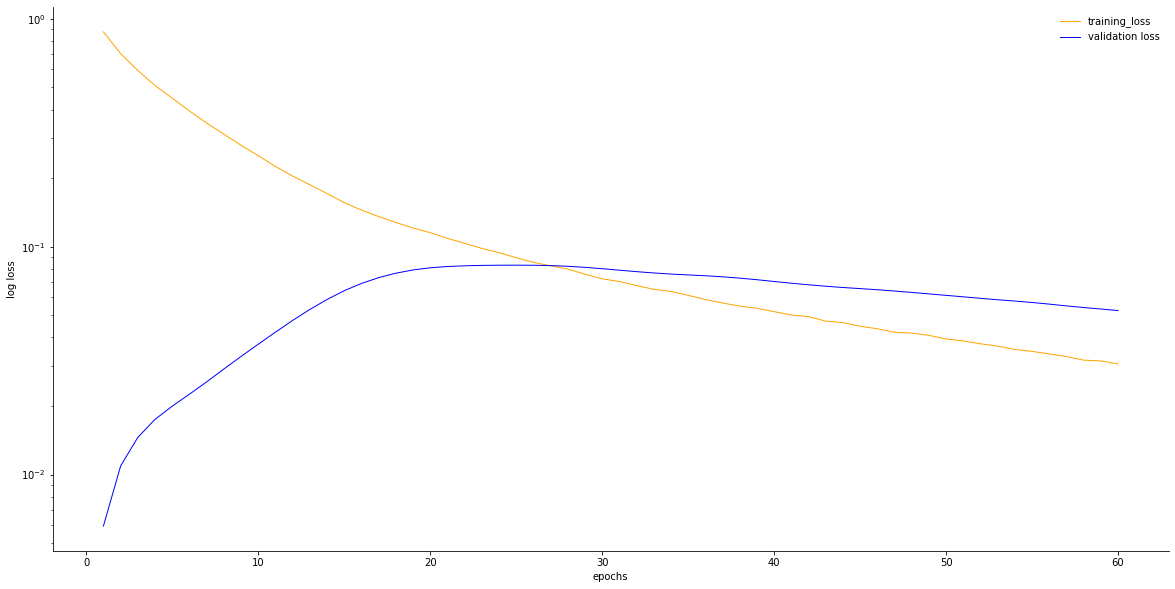

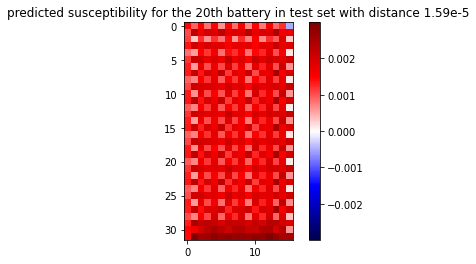

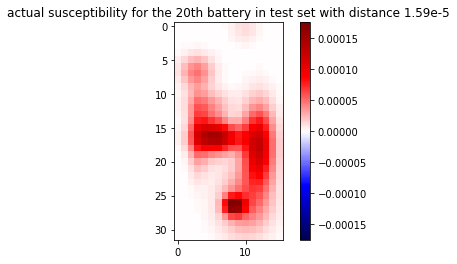

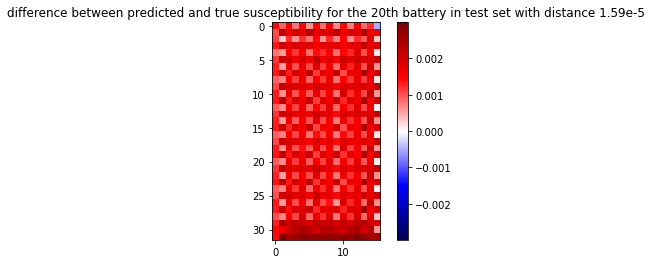

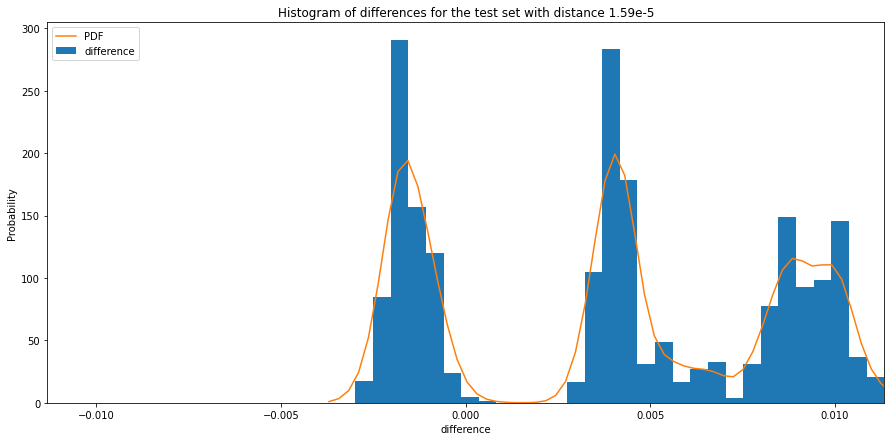

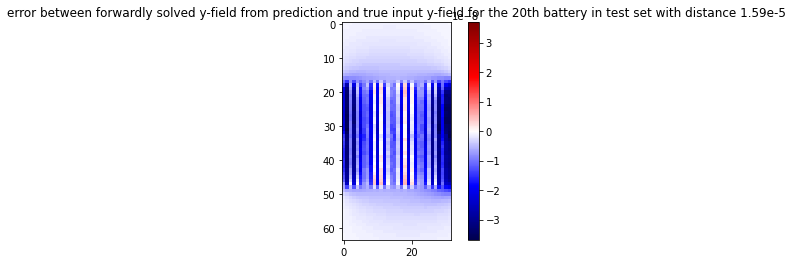

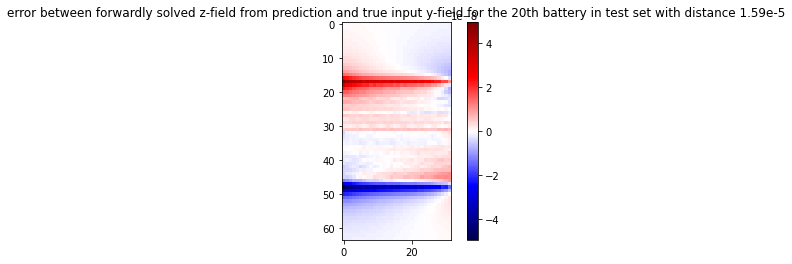

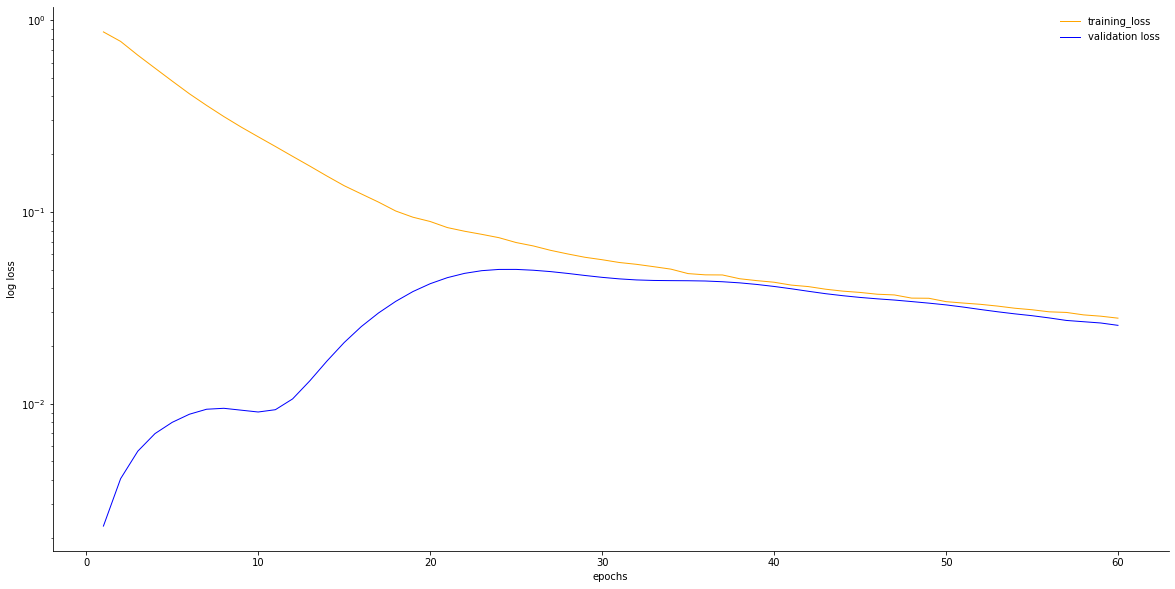

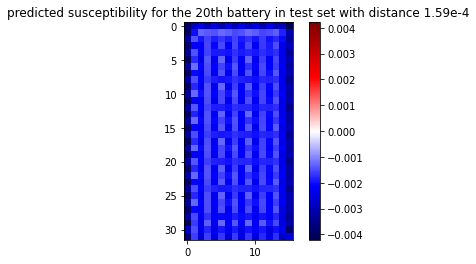

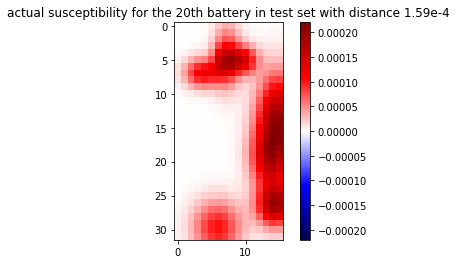

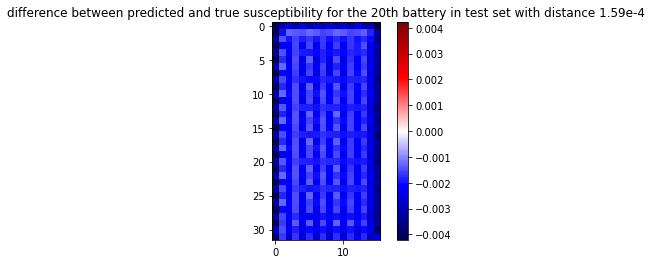

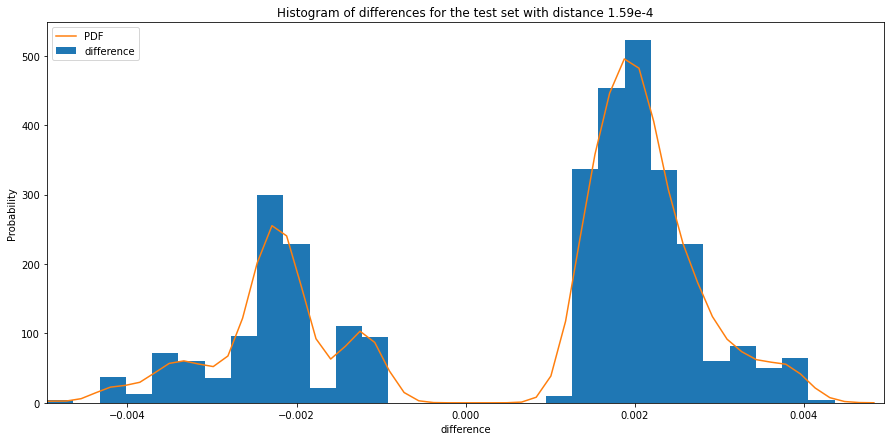

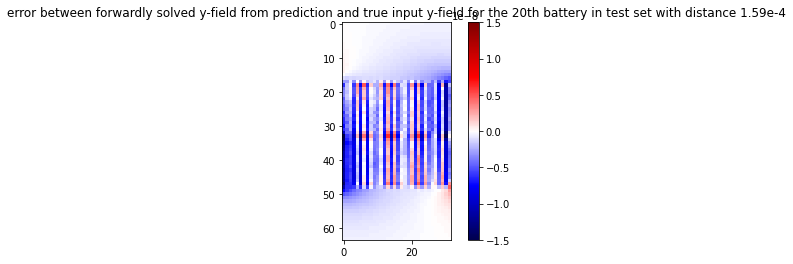

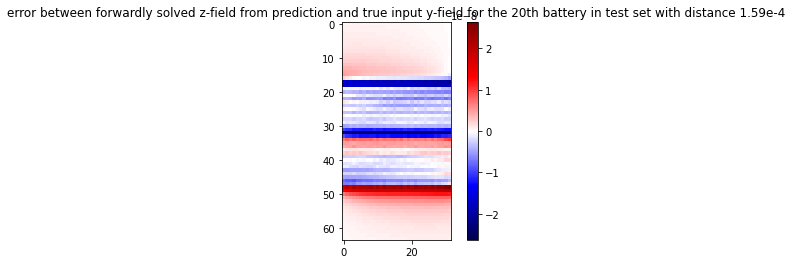

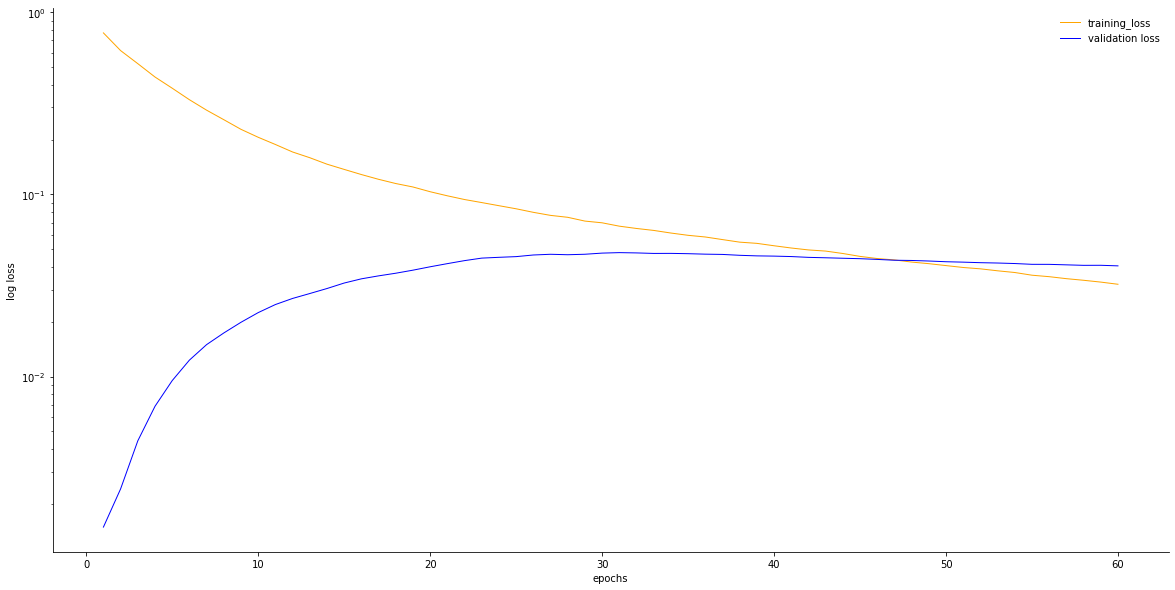

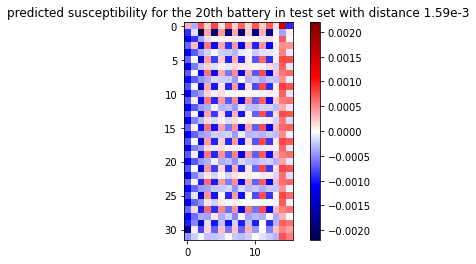

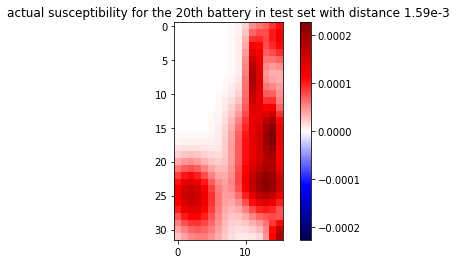

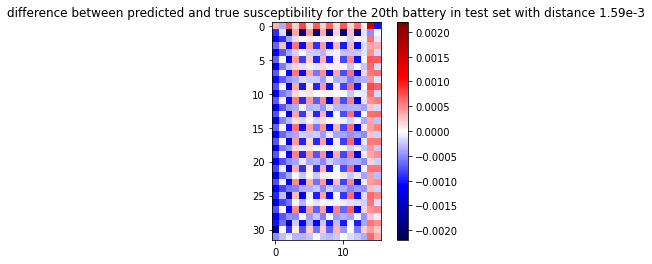

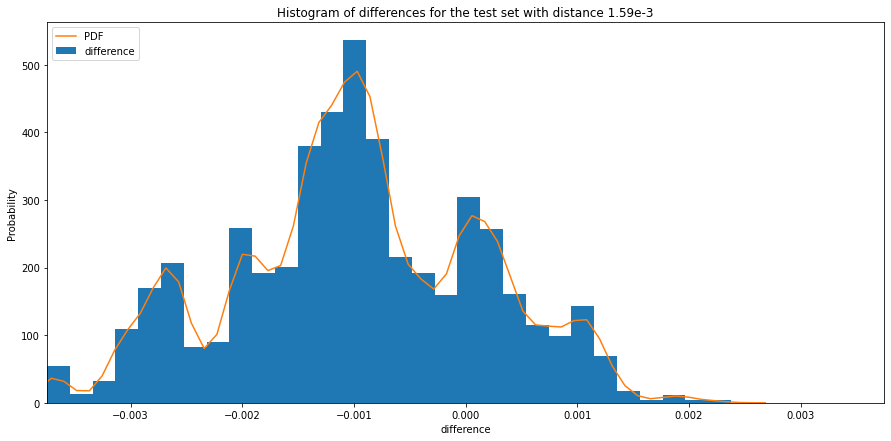

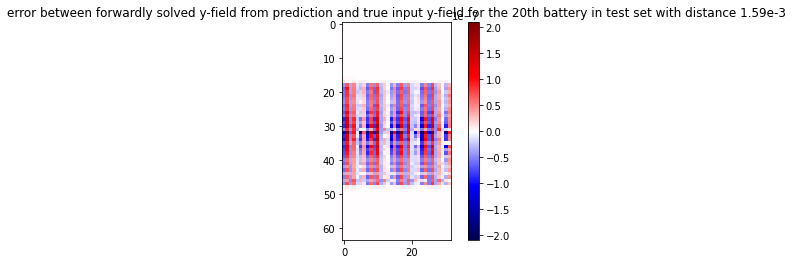

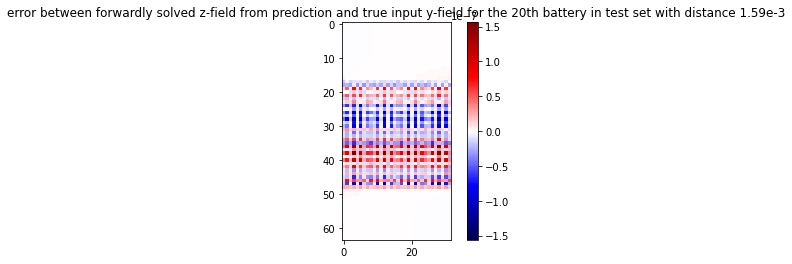

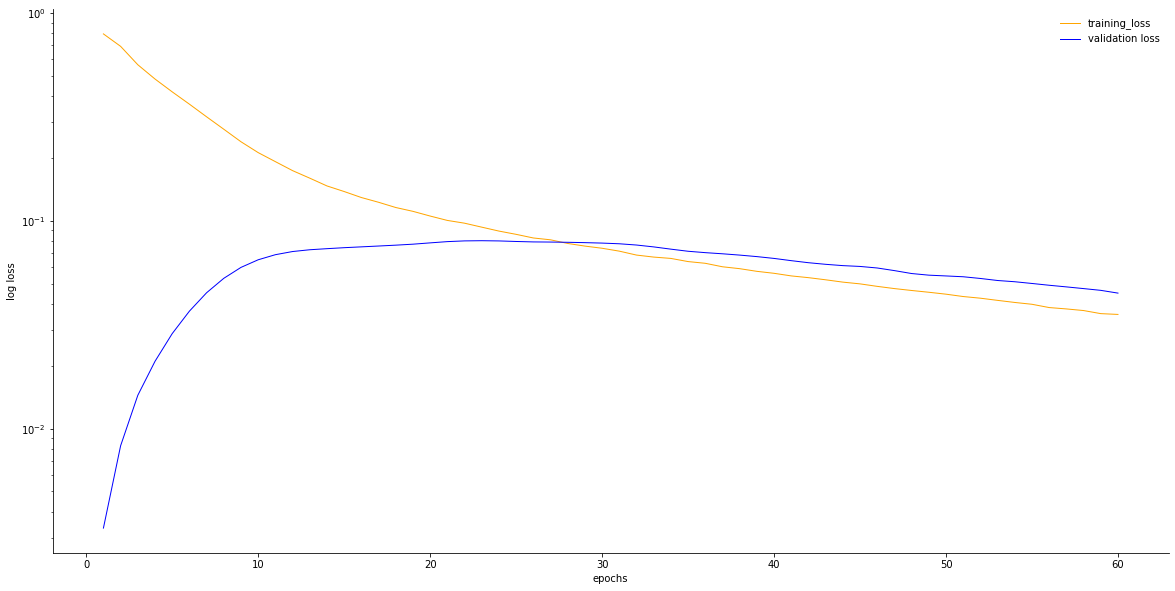

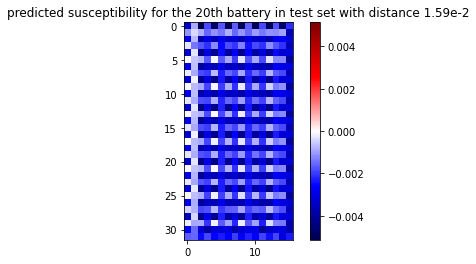

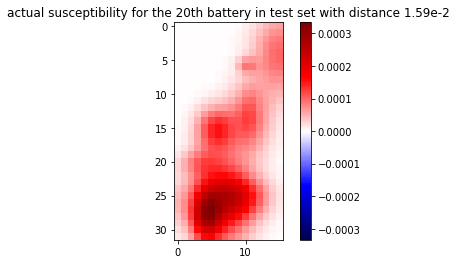

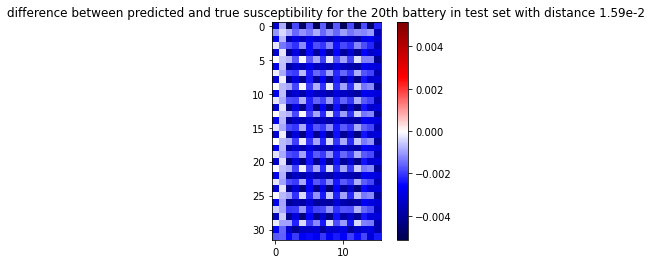

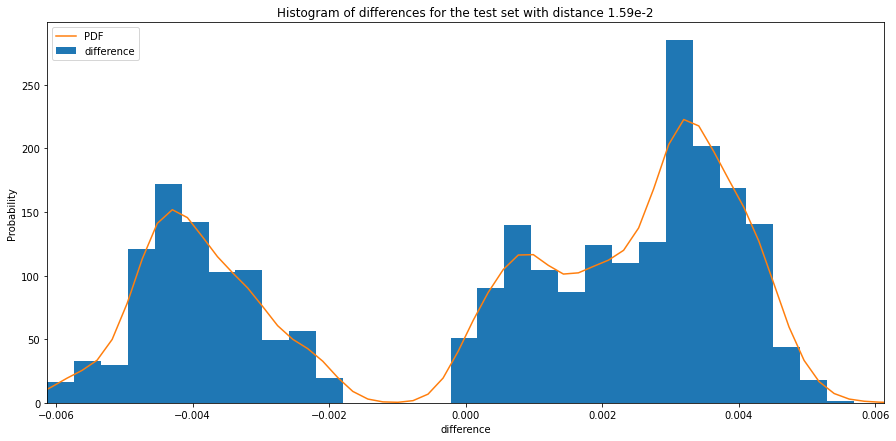

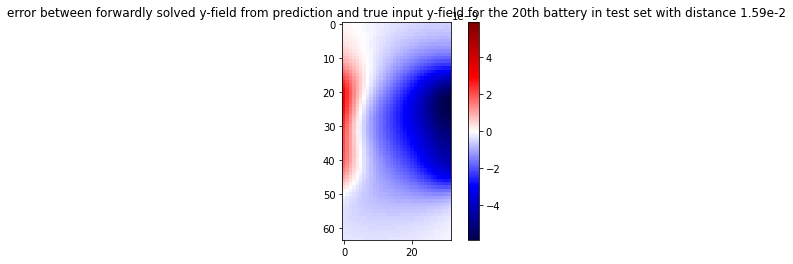

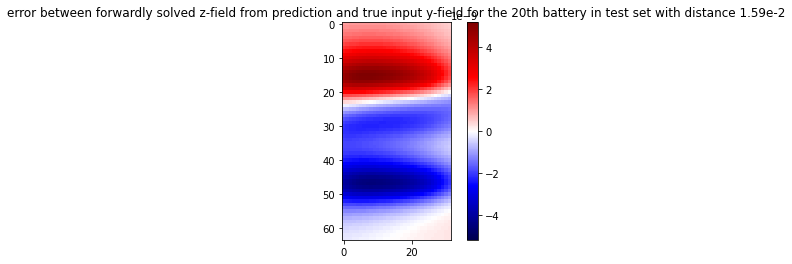

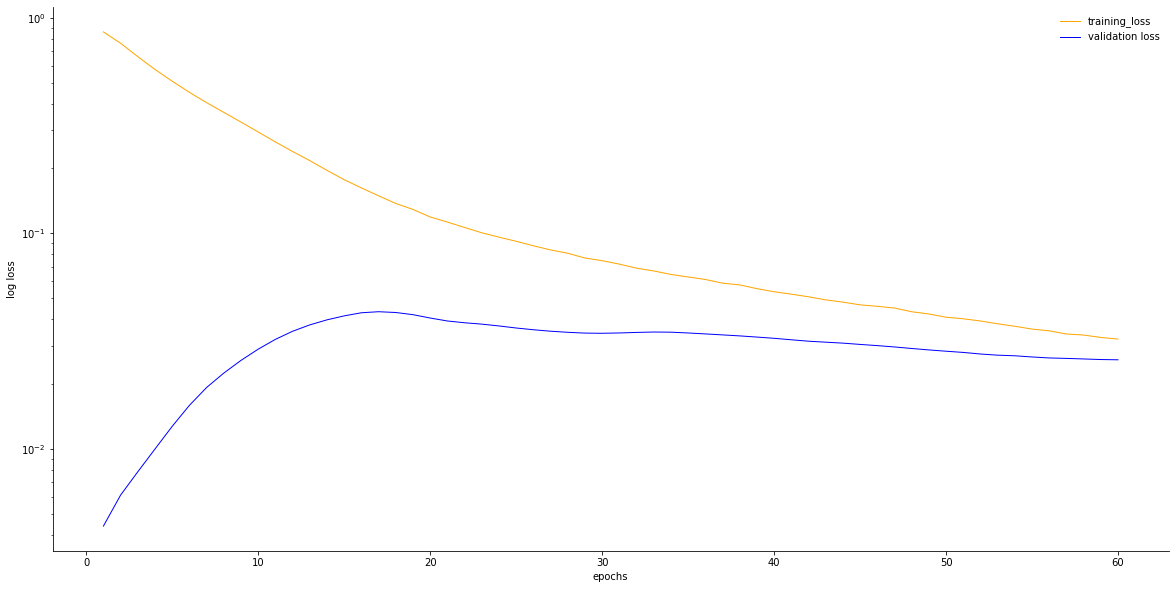

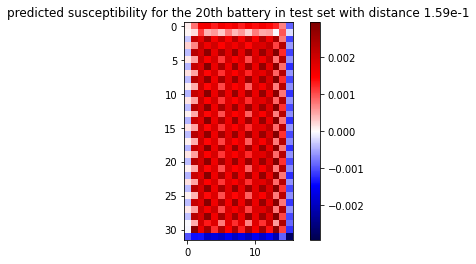

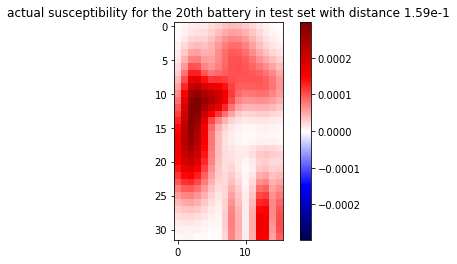

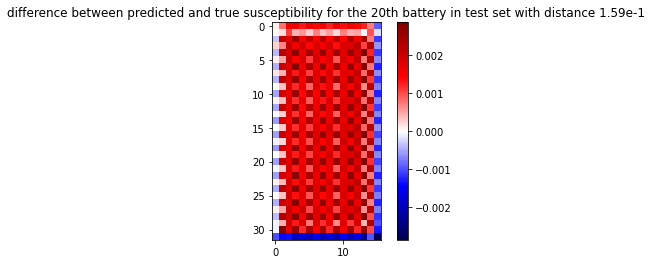

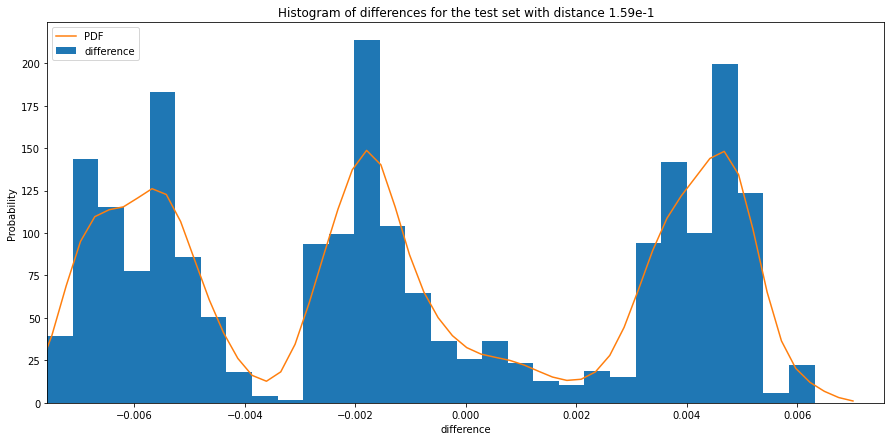

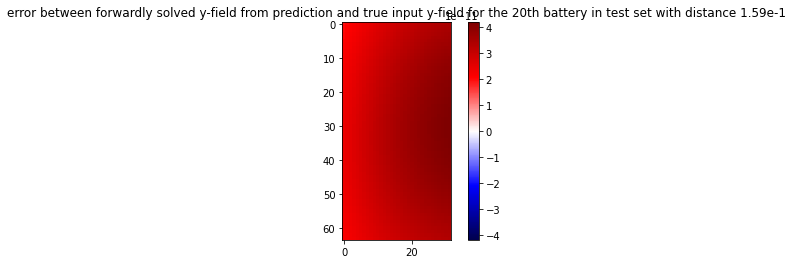

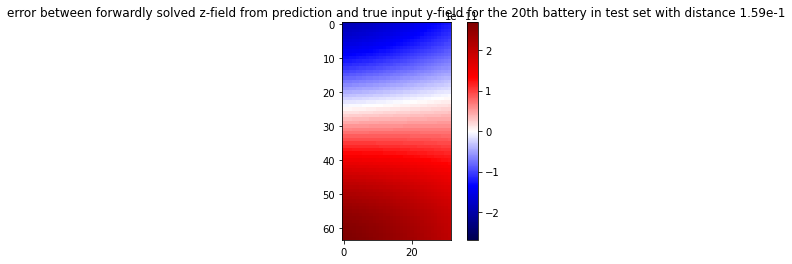

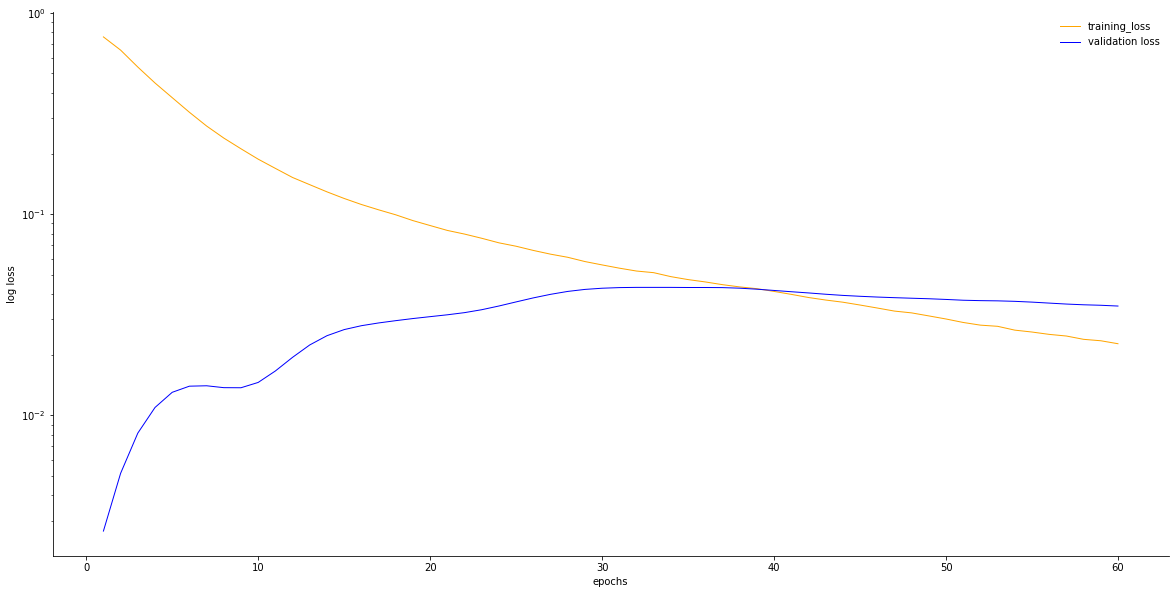

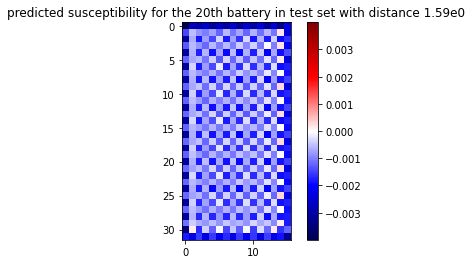

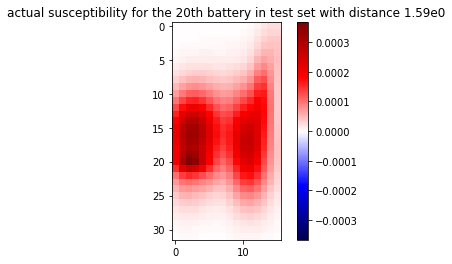

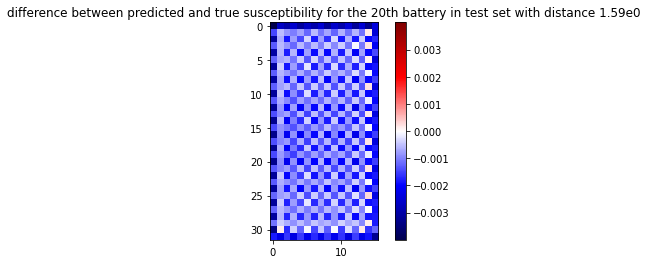

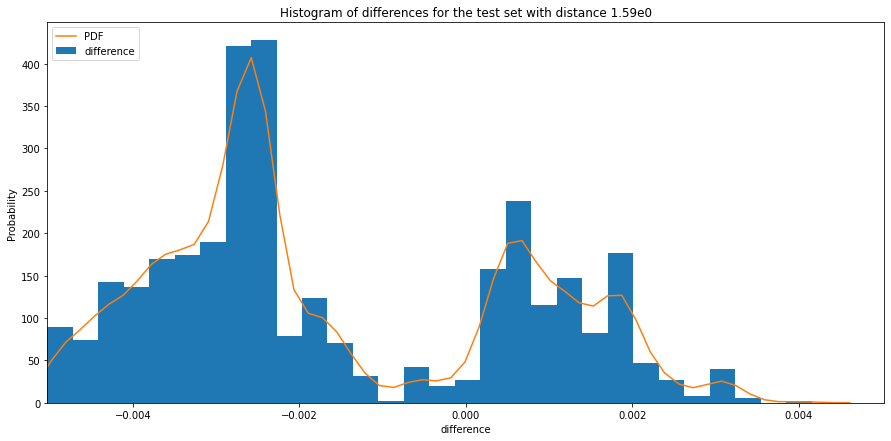

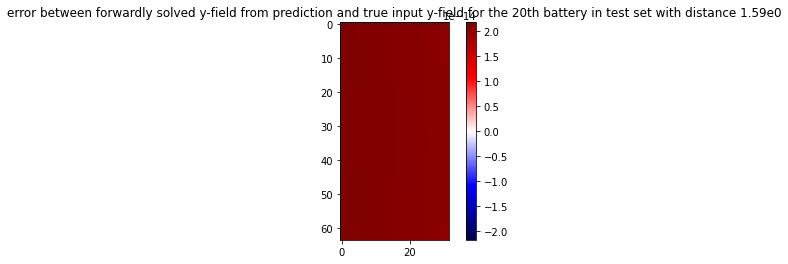

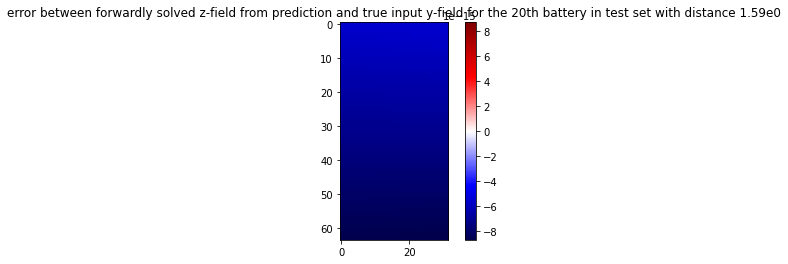

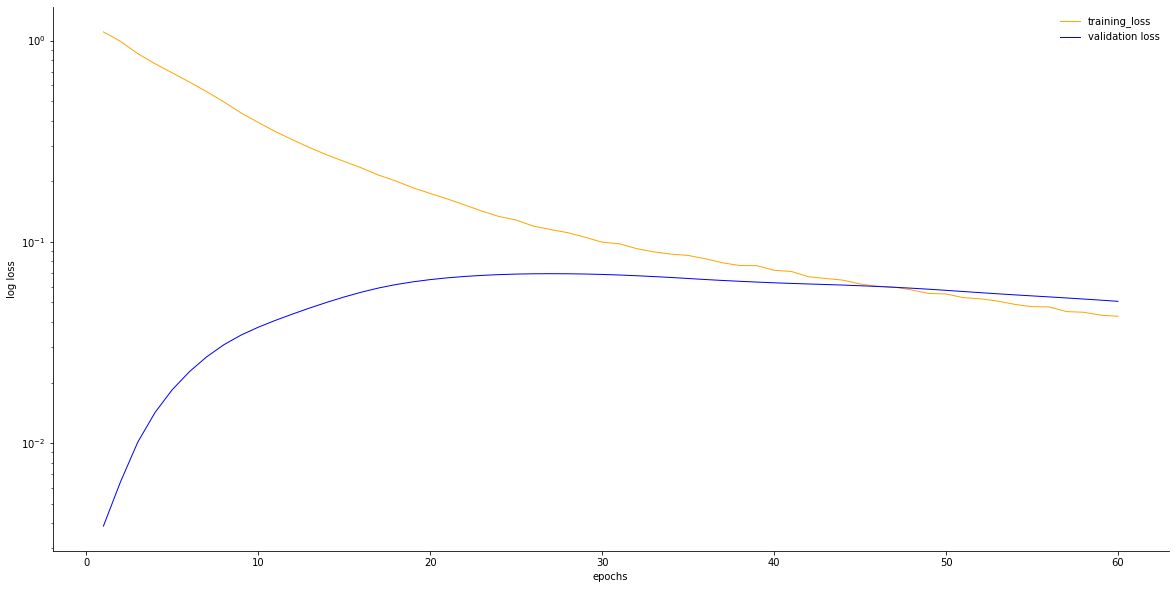

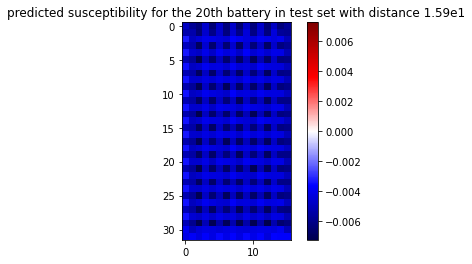

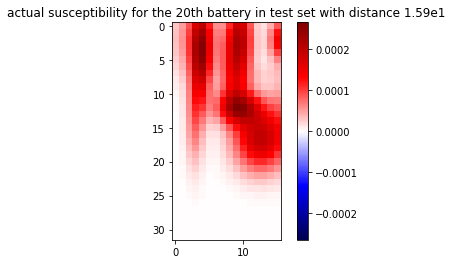

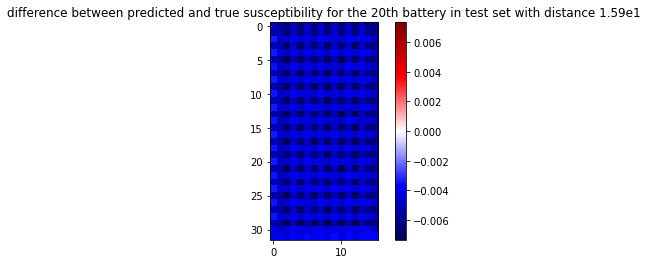

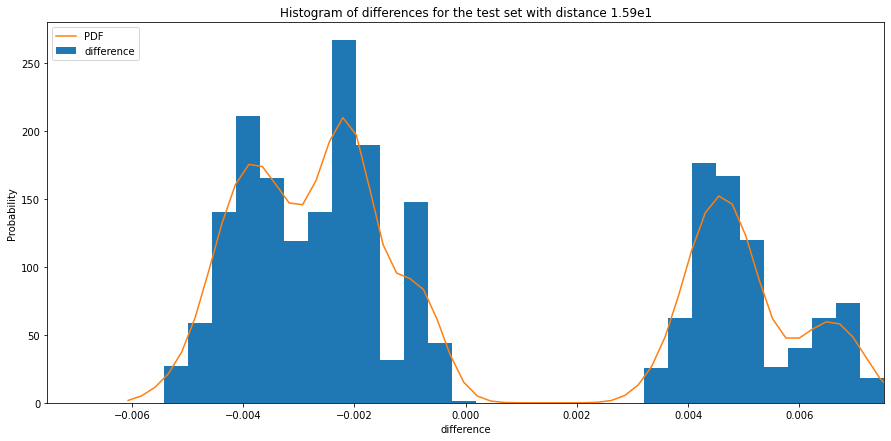

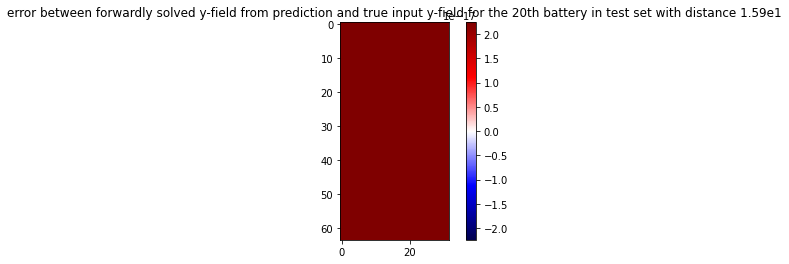

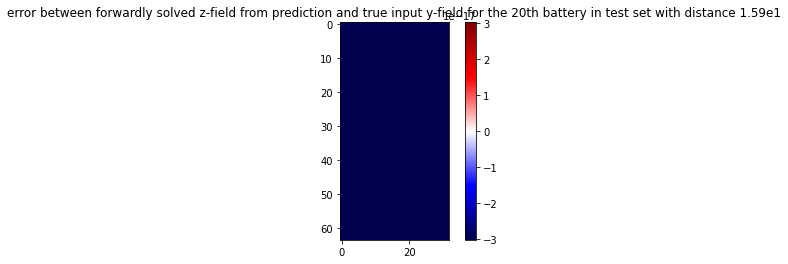

In [ ]:
result_dict = dict()

for key in set_dict.keys():
  dist=key
  specs_dict = dict()
  
  try:
    os.mkdir(str(key)) # make a directory before we can put things under it
  except:
    print("directory already exists")

  best_params = grid_search(set_dict[key]['train_images_t2b'], set_dict[key]['train_labels_t2b'],
                            set_dict[key]['val_images_t2b'], set_dict[key]['val_labels_t2b'], dist=key,
                            epo_lst=[60])
  specs_dict['best_val_loss_reached'] = best_params['best_val_loss_reached']
  specs_dict['training_time'] = best_params['training_time']
  specs_dict['val_loss_his'] = best_params['val_loss_his']
  specs_dict['train_loss_his'] = best_params['train_loss_his']

  # predict w the best model, or in this case, only 1 model, on the test set
  model_ht2b=tf.keras.models.load_model(str(dist)+'/model.best.h5',
                                        custom_objects={'custom_loss_rmse': custom_loss_rmse})
  susax=2
  test_images_t2b = set_dict[key]['test_images_t2b']
  test_labels_t2b = set_dict[key]['test_labels_t2b']
  X_test = test_images_t2b
  y_pred_ht2 = model_ht2b.predict(test_images_t2b)

  plt.figure()
  imshow_center(y_pred_ht2[20,:,:,susax])
  plt.title("predicted susceptibility for the 20th battery in test set with distance 1.59e"+str(key))
  plt.savefig(str(dist)+"/test_20_pred.png")

  plt.figure()
  imshow_center(test_labels_t2b[20,:,:,susax])
  plt.title("actual susceptibility for the 20th battery in test set with distance 1.59e"+str(key))
  plt.savefig(str(dist)+"/test_20_true.png")

  plt.figure()
  imshow_center(y_pred_ht2[20,:,:,susax]-test_labels_t2b[20,:,:,susax])
  # plot the the predicted susceptibility - actual susceptibility in the same chanel which is '2' for the 20th battery in test set
  # we want this difference to be as small as possible, not too extreme in either way
  plt.title("difference between predicted and true susceptibility for the 20th battery in test set with distance 1.59e"+str(key))
  plt.savefig(str(dist)+'/test_20_difference.png')

  test_diff = test_labels_t2b - y_pred_ht2
  test_diff = tf.keras.backend.flatten(test_diff)
  plt.figure(figsize=(15,7))
  plt.hist(test_diff, bins=30, density=True, label='difference');
  mn, mx = plt.xlim()
  plt.xlim(mn, mx)
  kde_xs = np.linspace(mn, mx, 60)
  kde = stats.gaussian_kde(test_diff)
  plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
  plt.legend(loc="upper left")
  plt.ylabel('Probability')
  plt.xlabel('difference')
  range = np.max([np.abs(np.min(test_diff)), np.abs(np.max(test_diff))])
  plt.xlim(-range, range)
  plt.title("Histogram of differences for the test set with distance 1.59e"+str(key));
  plt.savefig(str(dist)+"/test_diff_hist.png")

  yf,zf=calcfield(y_pred_ht2[20,:,:,:], A_dict[key])
  # calculate the y(dimension 0) and z(dimension 1) component of the magnetic field for the 20th battery
  # from the predicted susceptibility output
  # so we are kind of like recreating the input to see if it is the same as the actual input
  # to see if the model learned the dipole forward kernel well

  plt.figure()
  imshow_center(np.squeeze(X_test[0,:,:,0])-yf)
  plt.title("error between forwardly solved y-field from prediction and true input y-field for the 20th battery in test set with distance 1.59e"+str(key))
  plt.savefig(str(dist)+"/test_20_yfield_diff.png")

  plt.figure()
  imshow_center(np.squeeze(X_test[0,:,:,1])-zf)
  plt.title("error between forwardly solved z-field from prediction and true input y-field for the 20th battery in test set with distance 1.59e"+str(key))
  plt.savefig(str(dist)+"/test_20_zfield_diff.png")

  final_loss = custom_loss_rmse(test_labels_t2b, y_pred_ht2)
  print('final RMSE loss on test set:', final_loss.numpy())
  NRMSE = final_loss/K.mean(test_labels_t2b)
  print('final normalized RMSE loss (div mean) on the test set:', NRMSE.numpy())
  RMSE_range = final_loss /(tf.reduce_max(test_labels_t2b) - tf.reduce_min(test_labels_t2b))
  print('final normalized RMSE loss (div range) on the test set:', RMSE_range.numpy())
  test_arr = tf.keras.backend.flatten(test_labels_t2b).numpy()
  IQR = stats.iqr(test_arr)
  RMSE_IQR = final_loss/IQR
  print('final normalized RMSE loss (div IQR) on the test set:', RMSE_IQR.numpy())
  print('final norm of the difference tensor:', tf.norm(y_pred_ht2-test_labels_t2b).numpy())
  Boll_NRMSE = tf.norm(y_pred_ht2-test_labels_t2b) / tf.norm(test_labels_t2b)
  print('final Bollman normalized RMSE loss on the test set:', Boll_NRMSE.numpy())  

  specs_dict['final_RMSE'] = final_loss.numpy()
  specs_dict['NRMSE'] = NRMSE.numpy()
  specs_dict['RMSE_range'] = RMSE_range.numpy()
  specs_dict['RMSE_IQR'] = RMSE_IQR.numpy()
  specs_dict['Boll_NRMSE'] = Boll_NRMSE.numpy()

  result_dict[key] = specs_dict

  print(100*'|')

In [ ]:
result_dict.keys()

dict_keys([-8, -7, -6, -5, -4, -3, -2, -1, 0, 1])

In [ ]:
assert result_dict.keys() == set_dict.keys()

In [ ]:
assert len(result_dict[-8].keys()) == 9
# there should be 9 different specs for each distance 

In [6]:
test = dict()
for i in range(-8,2,1):
  test[i] = 3

lst=[]
for i in test.keys():
  lst.append(i)

print(lst)

print([i for i in test.keys()])

[-8, -7, -6, -5, -4, -3, -2, -1, 0, 1]
[-8, -7, -6, -5, -4, -3, -2, -1, 0, 1]


In [ ]:
Boll_NRMSE_lst = []
best_val_loss_lst=[]
dict_lst = [i for i in result_dict.keys()]
for key in result_dict.keys():
  Boll_NRMSE_lst.append(result_dict[key]['Boll_NRMSE'])
  best_val_loss_lst.append(result_dict[key]['best_val_loss_reached'])

[-8, -7, -6, -5, -4, -3, -2, -1, 0, 1]
[134.16123668134205, 96.05432880282991, 102.35479687815973, 116.33948300128645, 48.2031825442873, 30.08062920969496, 72.30606596743408, 93.52660166151578, 57.38317914094432, 81.29718195508327]
****************************************************************************************************


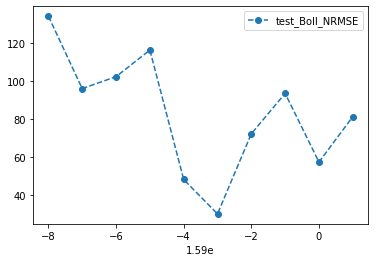

In [ ]:
print(dict_lst)
print(Boll_NRMSE_lst)
print(100*'*')
figure = plt.figure(figsize=None)
plt.plot(dict_lst, Boll_NRMSE_lst, label="test_Boll_NRMSE", linestyle='--', marker='o') 
# plt.yscale('log')
plt.legend()
plt.xlabel('1.59e')
plt.savefig('dist_vs_NRMSE.png')

[-8, -7, -6, -5, -4, -3, -2, -1, 0, 1]
[0.00607690219668825, 0.0047235235211999325, 0.004751005539786059, 0.005938476259366327, 0.002301736742719066, 0.0014909756170321036, 0.0033306948844877096, 0.004382196214016793, 0.0026586845358735015, 0.003875850515263803]
****************************************************************************************************


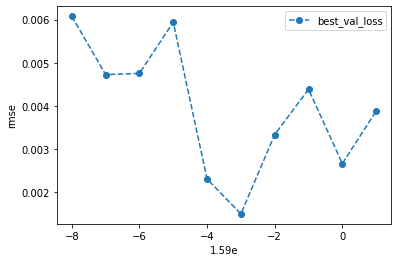

In [ ]:
print(dict_lst)
print(best_val_loss_lst)
print(100*'*')
plt.figure(figsize=None)
plt.plot(dict_lst, best_val_loss_lst, label="best_val_loss", linestyle='--', marker='o') 
plt.legend()
# plt.yscale('log')
plt.xlabel('1.59e')
plt.ylabel('rmse')
plt.savefig('dist_vs_val_loss.png')

In [ ]:
try:
  # save the final result dictionary
  # bc earlier versions of python does not support 'with' statement we have to do this?
  result_json = json.dumps(result_dict)
  f = open("result_dict.json","w")
  f.write(result_json)
  f.close()
  print('saved result dictionary')
  # load the json file later with
  # f = open("result_dict.json", "r")
  # try:
  #     result_dict = json.load(f)
  # finally:
  #     f.close()
except:
  print('could not save result dictionary')

saved result dictionary


In [ ]:
# save the final best_params dictionary
# bc earlier versions of python does not support 'with' statement we have to do this?
param_json = json.dumps(best_params)
f = open("best_params.json","w")
f.write(param_json)
f.close()

# load the json file later with
# f = open("best_params.json", "r")
# try:
#     best_params = json.load(f)
# finally:
#     f.close()

Epoch 1/60
1/2 [==============>...............] - ETA: 0s - loss: 1.0650
Epoch 00001: val_loss improved from inf to 0.00155, saving model to 0/current.best.h5
2/2 [==============================] - 1s 280ms/step - loss: 1.0693 - val_loss: 0.0015
Epoch 2/60
1/2 [==============>...............] - ETA: 0s - loss: 0.9922
Epoch 00002: val_loss did not improve from 0.00155
2/2 [==============================] - 0s 23ms/step - loss: 0.9687 - val_loss: 0.0036
Epoch 3/60
1/2 [==============>...............] - ETA: 0s - loss: 0.8430
Epoch 00003: val_loss did not improve from 0.00155
2/2 [==============================] - 0s 22ms/step - loss: 0.8269 - val_loss: 0.0061
Epoch 4/60
1/2 [==============>...............] - ETA: 0s - loss: 0.7374
Epoch 00004: val_loss did not improve from 0.00155
2/2 [==============================] - 0s 21ms/step - loss: 0.7247 - val_loss: 0.0086
Epoch 5/60
1/2 [==============>...............] - ETA: 0s - loss: 0.6489
Epoch 00005: val_loss did not improve from 0.00155


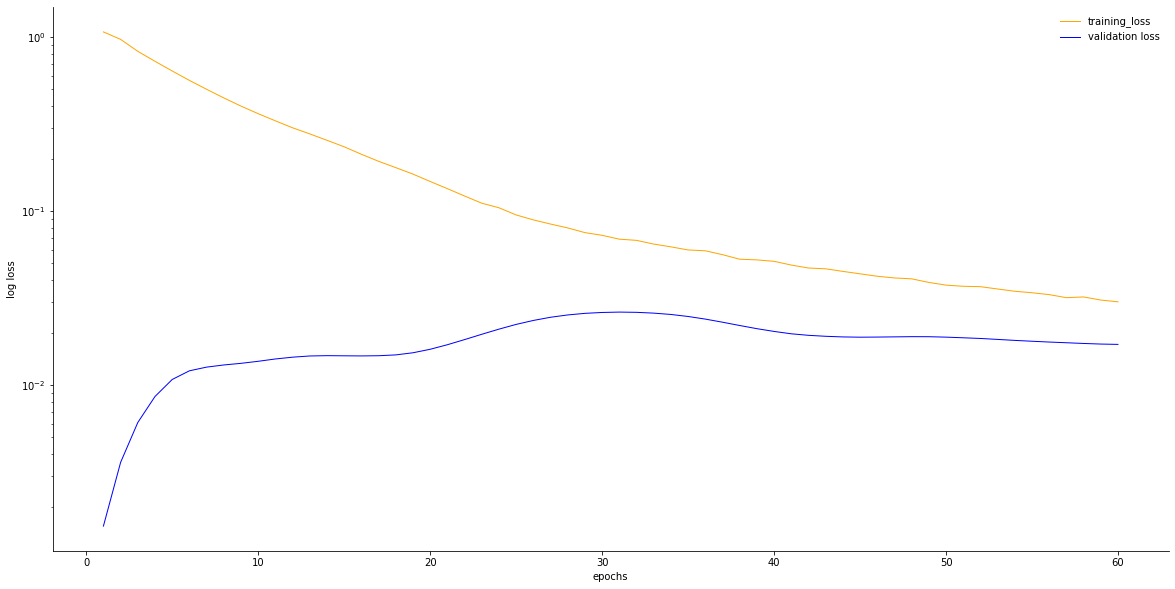

In [ ]:
key = 0
specs_dict = dict()
best_params = grid_search(set_dict[key]['train_images_t2b'], set_dict[key]['train_labels_t2b'],
                          set_dict[key]['val_images_t2b'], set_dict[key]['val_labels_t2b'], dist=key,
                          epo_lst=[60])
specs_dict['best_val_loss_reached'] = best_params['best_val_loss_reached']
specs_dict['training_time'] = best_params['training_time']
specs_dict['val_loss_his'] = best_params['val_loss_his']
specs_dict['train_loss_his'] = best_params['train_loss_his']

# predict w the best model, or in this case, only 1 model, on the test set
model_ht2b=tf.keras.models.load_model(str(dist)+'/model.best.h5',custom_objects={'custom_loss_rmse': custom_loss_rmse})
susax=2
test_images_t2b = set_dict[key]['test_images_t2b']
test_labels_t2b = set_dict[key]['test_labels_t2b']
X_test = test_images_t2b
y_pred_ht2 = model_ht2b.predict(test_images_t2b)

# plt.figure()
# imshow_center(y_pred_ht2[20,:,:,susax])
# plt.title("predicted susceptibility for the 20th battery in test set")
# plt.savefig("test_20_pred.png")

# plt.figure()
# imshow_center(test_labels_t2b[20,:,:,susax])
# plt.title("actual susceptibility for the 20th battery in test set")
# plt.savefig("test_20_true.png")

# plt.figure()
# imshow_center(y_pred_ht2[20,:,:,susax]-test_labels_t2b[20,:,:,susax])
# # plot the the predicted susceptibility - actual susceptibility in the same chanel which is '2' for the 20th battery in test set
# # we want this difference to be as small as possible, not too extreme in either way
# plt.title("error between predicted and true susceptibility")
# plt.savefig('test_20_error.png')

# test_diff = test_labels_t2b - y_pred_ht2
# test_diff = tf.keras.backend.flatten(test_diff)
# plt.figure(figsize=(15,7))
# plt.hist(test_diff, bins=30, density=True, label='difference');
# mn, mx = plt.xlim()
# plt.xlim(mn, mx)
# kde_xs = np.linspace(mn, mx, 60)
# kde = stats.gaussian_kde(test_diff)
# plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
# plt.legend(loc="upper left")
# plt.ylabel('Probability')
# plt.xlabel('difference')
# range = np.max([np.abs(np.min(test_diff)), np.abs(np.max(test_diff))])
# plt.xlim(-range, range)
# plt.title("Histogram of differences");
# plt.savefig("test_diff_hist.png")

# yf,zf=calcfield(y_pred_ht2[20,:,:,:])
# # calculate the y(dimension 0) and z(dimension 1) component of the magnetic field for the 20th battery
# # from the predicted susceptibility output
# # so we are kind of like recreating the input to see if it is the same as the actual input
# # to see if the model learned the dipole forward kernel well

# plt.figure()
# imshow_center(np.squeeze(X_test[0,:,:,0])-yf)
# plt.title("error between forwardly solved y-field from prediction and true input y-field")
# plt.savefig('test_20_yfield_diff.png')

# plt.figure()
# imshow_center(np.squeeze(X_test[0,:,:,1])-zf)
# plt.title("error between forwardly solved z-field from prediction and true input z-field")
# plt.savefig('test_20_zfield_diff.png')

final_loss = custom_loss_rmse(test_labels_t2b, y_pred_ht2)
print('final RMSE loss on test set:', final_loss.numpy())
NRMSE = final_loss/K.mean(test_labels_t2b)
print('final normalized RMSE loss (div mean) on the test set:', NRMSE.numpy())
RMSE_range = final_loss /(tf.reduce_max(test_labels_t2b) - tf.reduce_min(test_labels_t2b))
print('final normalized RMSE loss (div range) on the test set:', RMSE_range.numpy())
test_arr = tf.keras.backend.flatten(test_labels_t2b).numpy()
IQR = stats.iqr(test_arr)
RMSE_IQR = final_loss/IQR
print('final normalized RMSE loss (div IQR) on the test set:', RMSE_IQR.numpy())
print('final norm of the difference tensor:', tf.norm(y_pred_ht2-test_labels_t2b).numpy())
Boll_NRMSE = tf.norm(y_pred_ht2-test_labels_t2b) / tf.norm(test_labels_t2b)
print('final Bollman normalized RMSE loss on the test set:', Boll_NRMSE.numpy())  

specs_dict['final_loss'] = final_loss.numpy()
specs_dict['NRMSE'] = NRMSE.numpy()
specs_dict['RMSE_range'] = RMSE_range.numpy()
specs_dict['RMSE_IQR'] = RMSE_IQR.numpy()
specs_dict['Boll_NRMSE'] = Boll_NRMSE.numpy()

In [ ]:
specs_dict.keys()

dict_keys(['best_val_loss_reached', 'training_time', 'val_loss_his', 'train_loss_his', 'final_loss', 'NRMSE', 'RMSE_range', 'RMSE_IQR', 'Boll_NRMSE'])

In [ ]:
specs_dict['best_val_loss_reached']

0.001546087570897018

In [ ]:
specs_dict['Boll_NRMSE']

83.64677965730738